# The 3D moving sofa problem

This notebook contains code to verify and visualise the construction that
AlphaEvolve found for the 3D moving sofa problem reported in
_Mathematical Discovery and Exploration at Scale_, 2025.

The **3D moving sofa problem** is a 3D generalisation of the
[2D moving sofa problem](https://en.wikipedia.org/wiki/Moving_sofa_problem). In
the 3D problem, the goal is to find the largest volume 3D shape that can move
through a 3D corridor with two 90-degree turns: one in the X-Y plane and one in
the Y-Z plane.

Important: Run this notebook in a Colab runtime that has GPU or TPU support.
We have tested this notebook on a public Colab **T4 GPU** runtime. To quickly
see visualisations of the sofa, you can run this notebook as-is in a few
minutes. However, to verify the volume = 1.81 result takes about 4 hours on a
T4 GPU runtime.

In [ ]:
# @title Imports

from collections.abc import Callable, Generator
import time
import jax
import jax.numpy as jnp
from jax.scipy.spatial import transform
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import IPython
from IPython.display import HTML, display

## Moving sofa code

In [ ]:
# @title Corridor

"""
The corridor has width and height CORRIDOR_WIDTH, and it has three segments:

1. "The X segment": 0 <= y <= CORRIDOR_WIDTH, 0 <= z <= CORRIDOR_WIDTH, x <= 0.

2. "The Y segment": 0 <= x <= CORRIDOR_WIDTH, 0 <= z <= CORRIDOR_WIDTH,
  0 <= y <= MIDDLE_LENGTH + CORRIDOR_WIDTH.

3. "The Z segment": 0 <= x <= CORRIDOR_WIDTH,
  MIDDLE_LENGTH + CORRIDOR_WIDTH <= y <= MIDDLE_LENGTH + 2*CORRIDOR_WIDTH,
  0 <= z.

These can be seen in the last visualisation in this notebook.
"""

CORRIDOR_WIDTH = 1.0
MIDDLE_LENGTH = 4.0  # Length of middle segment (along Y)

def are_points_in_corridor(points: jnp.ndarray) -> jnp.ndarray:
  """Checks which points in an array lie within the corridor."""
  x, y, z = points[:, 0], points[:, 1], points[:, 2]
  w = CORRIDOR_WIDTH
  y_turn_coord = w + MIDDLE_LENGTH

  # First corridor segment (travelling x direction, for x<=0).
  mask1 = (x <= 0) & (y >= 0) & (y <= w) & (z >= 0) & (z <= w)

  # Second corridor segment (travelling y direction, for 0<=y<=y_turn_coord).
  mask2 = (
      (x >= 0) & (x <= w) & (y >= 0) & (y <= y_turn_coord) & (z >= 0) & (z <= w)
  )

  #  Third corridor segment (travelling z direction, for 0<=z).
  mask3 = (
      (x >= 0)
      & (x <= w)
      & (y >= y_turn_coord)
      & (y <= y_turn_coord + w)
      & (z >= 0)
  )

  return mask1 | mask2 | mask3


@jax.jit
def check_box_in_corridor(
    x_extrema: jnp.ndarray,
    y_extrema: jnp.ndarray,
    z_extrema: jnp.ndarray,
) -> jnp.ndarray:
  """Checks if a box is in the corridor.

  The box is represented by its extrema in x, y, and z dimensions.

  Args:
    x_extrema: A jnp array of shape (2,) containing two floats representing the
      minimum and maximum x coordinates of the box.
    y_extrema: A jnp array of shape (2,) containing two floats representing the
      minimum and maximum y coordinates of the box.
    z_extrema: A jnp array of shape (2,) containing two floats representing the
      minimum and maximum z coordinates of the box.

  Returns:
    A boolean indicating whether the box is entirely within the corridor.
  """
  # The box is in the corridor iff all 8 of its corners are in the corridor.
  corners = jnp.array([
      [x_extrema[0], y_extrema[0], z_extrema[0]],
      [x_extrema[0], y_extrema[0], z_extrema[1]],
      [x_extrema[0], y_extrema[1], z_extrema[0]],
      [x_extrema[0], y_extrema[1], z_extrema[1]],
      [x_extrema[1], y_extrema[0], z_extrema[0]],
      [x_extrema[1], y_extrema[0], z_extrema[1]],
      [x_extrema[1], y_extrema[1], z_extrema[0]],
      [x_extrema[1], y_extrema[1], z_extrema[1]],
  ])
  return are_points_in_corridor(corners).all()

In [ ]:
# @title Initial grid of sofa points

"""
We model the sofa as a collection of points.

We initialise the sofa as a 3D grid of (x,y,z) points, forming a cuboidal block
with -INITIAL_SOFA_LENGTH <= x <= 0, 0 <= y <= CORRIDOR_WIDTH and
0 <= z <= CORRIDOR_WIDTH.

This initial grid of points later gets "shaved down" by the sofa's path through
the corridor, so the final sofa is only the points that "survive" (i.e. stay
inside the corridor) for the whole path.
"""

INITIAL_SOFA_LENGTH = 4.0  # The x-dim length of the initial cuboidal block


def get_grid_dims_and_coords(
    grid_fineness: float,
) -> tuple[tuple[int, int, int], tuple[np.ndarray, np.ndarray, np.ndarray]]:
  """Returns dimensions and coordinates for grid of given fineness.

  Args:
    grid_fineness: the desired space between the points.

  Returns:
    dimensions: a tuple of (num_x, num_y, num_z), where num_x is the number of
      points along the x-axis, etc.
    coords: a tuple of (x_coords, y_coords, z_coords), where x_coords is an
      array of length num_x containing the x-coordinates of the grid points,
      from -INITIAL_SOFA_LENGTH to 0 inclusive. y_coords and z_coords go from
      0 to CORRIDOR_WIDTH inclusive. The space between the points is no more
      than grid_fineness.
  """

  # Compute the number of points along each dimension
  num_x = int(np.ceil(INITIAL_SOFA_LENGTH / grid_fineness) + 1)
  num_y = int(np.ceil(CORRIDOR_WIDTH / grid_fineness) + 1)
  num_z = int(np.ceil(CORRIDOR_WIDTH / grid_fineness) + 1)

  # Create the coordinate vectors
  x_coords = np.linspace(-INITIAL_SOFA_LENGTH, 0, num_x)
  y_coords = np.linspace(0, CORRIDOR_WIDTH, num_y)
  z_coords = np.linspace(0, CORRIDOR_WIDTH, num_z)

  return (num_x, num_y, num_z), (x_coords, y_coords, z_coords)


def generate_initial_sofa_points_in_batches(
    grid_fineness: float,
    max_batch_size: int = int(5e7),
) -> tuple[Callable[[], Generator[np.ndarray, None, None]], int, int]:
  """Generates the initial grid of sofa points in batches.

  Args:
    grid_fineness: The spacing between points on the grid.
    max_batch_size: The maximum number of points in each batch.

  Returns:
    generate_points: a function which yields numpy arrays of shape (B, 3)
      representing a batch of points, where B <= max_batch_size.
    total_points: total number of sofa points that will be generated.
    num_batches: number of batches that will be generated.
  """
  dims, (x_coords, y_coords, z_coords) = get_grid_dims_and_coords(grid_fineness)
  total_points = dims[0] * dims[1] * dims[2]

  print(f'Total points to generate: {total_points:_}, max_batch_size={max_batch_size:_}, with {grid_fineness=}')

  batch_start_indices = range(0, total_points, max_batch_size)
  num_batches = len(batch_start_indices)

  def generate_points():

    # Generate points in batches
    for batch_number, batch_start_index in enumerate(batch_start_indices):
      # Determine the indices for the current batch
      batch_end_index = min(batch_start_index + max_batch_size, total_points)

      # Create a range of linear indices for the flattened grid
      linear_indices = np.arange(batch_start_index, batch_end_index)

      # Convert linear indices to multi-dimensional indices (ix, iy, iz)
      # This is the core vectorized operation for batch generation
      ix, iy, iz = np.unravel_index(linear_indices, dims)  # pylint: disable=unbalanced-tuple-unpacking

      # Create the batch of points using the coordinate vectors
      batch_points = np.vstack([x_coords[ix], y_coords[iy], z_coords[iz]]).T

      print(f'Yielding batch {batch_number}/{num_batches} of size {len(batch_points):_}')
      yield batch_points

  return generate_points, total_points, num_batches

In [ ]:
# @title Path smoothing

"""
A path is a sequence of poses.

A pose is a 6-tuple (x, y, z, yaw, pitch, roll), where (yaw, pitch, roll)
represents a rotation of the sofa (see https://en.wikipedia.org/wiki/Euler_angles)
and (x, y, z) is a translation of the sofa.

The sofa points are initialised as a block with -INITIAL_SOFA_LENGTH <= x <= 0,
0 <= y <= CORRIDOR_WIDTH and 0 <= z <= CORRIDOR_WIDTH (this places the block
just before the first turn in the corridor). To put the sofa in the pose
(x, y, z, yaw, pitch, roll), we rotate these points around the origin using
(yaw, pitch, roll), then translate the rotated sofa by (x, y, z).

After AlphaEvolve proposes a path for the sofa (i.e., a sequence of poses), we
do two things:
1. We add fixed start and end poses to ensure the sofa travels from the start
  to the end of the corridor.
2. We smooth the path. If the path has big jumps in rotation or translation, we
  add extra poses to make sure the difference between each pair of poses is
  small. This typically helps more points survive the path.

The last visualisation cell in this notebook shows what the paths and poses look
like.
"""

# We require the front of the sofa to start START_END_DIST from the first corner
# and the back of the sofa to finish START_END_DIST from the second corner.
START_END_DIST = 3.0


def add_start_and_end_poses(path: np.ndarray) -> np.ndarray:
  """Adds start and end poses to the path."""
  # Start Pose: front of sofa START_END_DIST from the first corner, facing +X
  start_pose = [-START_END_DIST, 0.0, 0.0, 0.0, 0.0, 0.0]

  # End pose: back of sofa START_END_DIST from last corner, facing +Z
  end_y = 2 * CORRIDOR_WIDTH + MIDDLE_LENGTH
  end_z = CORRIDOR_WIDTH + START_END_DIST + INITIAL_SOFA_LENGTH
  end_pose = [0.0, end_y, end_z, 90.0, 90.0, 90.0]

  # Prepend start pose and append end pose
  return np.vstack([start_pose, path, end_pose])


def smooth_path_to_tolerances(
    path: np.ndarray,
    translation_tol: float,
    rotation_tol: float,
) -> np.ndarray:
  """Smoothes the path so translation and rotation diffs are within tolerances.

  Args:
    path: A numpy array of shape (num_steps, 6) containing (x, y, z, yaw, pitch,
      roll) poses.
    translation_tol: The tolerance for translation.
    rotation_tol: The tolerance for rotation in degrees.

  Returns:
    smoothed_path: A numpy array of shape (smoothed_num_steps, 6) containing the
      smoothed path. All adjacent poses have a translation diff of no more than
      translation_tol. All adjacent poses have a yaw diff, pitch diff, and roll
      diff each of no more than rotation_tol.
  """
  smoothed_path_list = [path[0].tolist()]
  for i in range(len(path) - 1):
    p1 = path[i]
    p2 = path[i + 1]
    translation_diff = np.linalg.norm(p2[:3] - p1[:3])
    rotation_diff = np.max(np.abs(p2[3:] - p1[3:]))  # Simple angle check

    num_interp_translation = 0
    if translation_diff > translation_tol:
      num_interp_translation = int(np.ceil(translation_diff / translation_tol))
    num_interp_rotation = 0
    if rotation_diff > rotation_tol:
      num_interp_rotation = int(np.ceil(rotation_diff / rotation_tol))
    num_interp = max(1, num_interp_translation, num_interp_rotation)

    if num_interp > 1:
      for j in range(1, num_interp):
        fraction = j / num_interp
        interpolated_point = p1 + fraction * (p2 - p1)
        smoothed_path_list.append(interpolated_point.tolist())
    smoothed_path_list.append(list(p2))

  print(f'Smoothed path length {len(path):_} to smoothed_path length {len(smoothed_path_list):_} with {translation_tol=} and {rotation_tol=}')
  return np.array(smoothed_path_list)


In [ ]:
# @title Pose survival

"""This cell contains code to check which points are in-corridor at a given pose."""

def transform_points(
    points: jnp.ndarray, rotation_matrix: jnp.ndarray, translation: jnp.ndarray
) -> jnp.ndarray:
  """Applies the rotation then the translation to the points.

  Args:
    points: an array of shape (num_points, 3) containing the points (of the
      initial sofa grid) to check.
    rotation_matrix: a rotation matrix, shape (3, 3).
    translation: a translation, shape (3,).

  Returns:
    transformed_points: shape (num_points, 3).
  """
  rotated_points = points @ rotation_matrix.T  # (num_points, 3)
  return rotated_points + translation  # (num_points, 3)


def _compute_points_surviving_poses_update_mask(
    points: jnp.ndarray,
    rotation_matrix: jnp.ndarray,
    translation: jnp.ndarray,
    survival_mask: jnp.ndarray,
) -> jnp.ndarray:
  """Updates the survival mask for a given rotation and translation.

  Args:
    points: an array of shape (num_points, 3) containing the points (of the
      initial sofa grid) to check.
    rotation_matrix: a rotation matrix, shape (3, 3).
    translation: a translation, shape (3,).
    survival_mask: boolean mask indicating which points are currently alive,
      shape (num_points,).

  Returns:
    updated survival mask, shape (num_points,). Any points which are not in the
      corridor for the provided pose (rotation and translation) are marked as
      not surviving.
  """
  transformed_points = transform_points(
      points, rotation_matrix, translation
  )  # (num_points, 3)
  in_corridor_mask = are_points_in_corridor(transformed_points)  # (num_points,)
  return survival_mask * in_corridor_mask


@jax.jit
def compute_points_surviving_poses(
    points: jnp.ndarray, poses: jnp.ndarray
) -> jnp.ndarray:
  """Computes which points are in the corridor at all poses.

  Args:
    points: an array of shape (num_points, 3) containing the points (of the
      initial sofa grid) to check.
    poses: shape (num_poses, 6) where each pose contains [x, y, z, yaw, pitch,
      roll].

  Returns:
    mask shape (num_points,) indicating which points are in the corridor at all
      poses.
  """
  initial_survival_mask = jnp.ones(len(points), dtype=jnp.bool)  # (num_points,)
  translations = poses[:, :3]  # (num_poses, 3)
  angles_deg = poses[:, 3:]  # (num_poses, 3)
  rotation = transform.Rotation.from_euler('zyx', angles_deg, degrees=True)
  rotation_matrices = jnp.array(rotation.as_matrix())  # (num_poses, 3, 3)

  # We use jax.lax.scan to iterate through path, applying update_survival_mask
  # to the survival mask.
  def scan_body(current_survival_mask, scan_inputs):
    rotation_matrix, translation = scan_inputs
    updated_survival_mask = _compute_points_surviving_poses_update_mask(
        points, rotation_matrix, translation, current_survival_mask
    )
    return updated_survival_mask, None

  scan_elements = (rotation_matrices, translations)
  final_survival_mask, _ = jax.lax.scan(
      scan_body, initial_survival_mask, scan_elements
  )
  return final_survival_mask


In [ ]:
# @title Rotation step survival

"""
This cell contains code to check which points survive a rotation step, i.e.
a movement from a first pose (x, y, z, yaw1, pitch1, roll1) to a second pose
(x, y, z, yaw2, pitch2, roll2) that differs only in the rotation.
"""

@jax.jit
def get_relative_rotation(
    pose1_ypr_deg: tuple[float, float, float],
    pose2_ypr_deg: tuple[float, float, float],
) -> transform.Rotation:
  """Computes the relative rotation from pose1 to pose2.

  Args:
    pose1_ypr_deg: The [yaw, pitch, roll] of the first pose in degrees.
    pose2_ypr_deg: The [yaw, pitch, roll] of the second pose in degrees.

  Returns:
    transform.Rotation object; the relative rotation from pose1 to pose2.
  """
  rot1 = transform.Rotation.from_euler(
      'zyx', jnp.array(pose1_ypr_deg), degrees=True
  )  # a transform.Rotation
  rot2 = transform.Rotation.from_euler(
      'zyx', jnp.array(pose2_ypr_deg), degrees=True
  )  # a transform.Rotation

  # For p and q two transform.Rotations, p * q denotes "q followed by p".
  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.__mul__.html
  rot_rel = rot2 * rot1.inv()

  # We now have rot_rel, a transform.Rotation satisfying rot_rel * rot1 = rot2,
  # i.e. rot1 followed by rot_rel is equal to rot2.
  return rot_rel


@jax.jit
def get_rotation_bounding_box(
    point: jnp.ndarray, rotation_axis: jnp.ndarray, rotation_angle_deg: float
) -> jnp.ndarray:
  """Computes the min and max x, y, and z coordinates of a point's rotation arc.

  If we rotate a 3D point around the origin using the provided axis and angle,
  this function computes the minimum and maximum x, y and z values on the arc
  travelled by the point. This forms a bounding box that completely contains
  the arc.

  Args:
    point: The initial 3D point, shape (3,).
    rotation_axis: The 3D rotation axis, shape (3,).
    rotation_angle_deg: The total rotation angle in degrees.

  Returns:
    A jnp array of shape (3, 2) containing the (min, max) coordinates
      for each dimension: [[min_x, max_x], [min_y, max_y], [min_z, max_z]].
  """
  # Convert angle to radians for trigonometric calculations
  rotation_angle_rad = jnp.deg2rad(rotation_angle_deg)

  # Ensure the rotation axis is a unit vector
  unit_axis = rotation_axis / jnp.linalg.norm(rotation_axis)

  # We use Rodrigues Rotation Formula:
  # https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula
  # The formula says that if p is our initial point and k is our unit_axis, then
  # the position p(theta) of the rotating point, for 0 <= theta <= rotation_angle_rad, is given by
  #   p(theta) = A*cos(theta) + B*sin(theta) + C
  # where:
  #   A = p - (p.k)k
  #   B = k x p
  #   C = (p.k)k
  p_dot_k = jnp.dot(point, unit_axis)  # scalar
  k_cross_p = jnp.cross(unit_axis, point)  # shape (3,)
  A = point - unit_axis * p_dot_k  # shape (3,)
  B = k_cross_p  # shape (3,)
  C = unit_axis * p_dot_k  # shape (3,)

  # Find critical points of Rodrigues formula.
  # These occur when the derivative is zero: -A*sin(theta) + B*cos(theta) = 0.
  # This simplifies to tan(theta) = B/A.
  # There are two solutions for theta in the [0, 2*pi) range for each dimension.
  theta_crit_base = jnp.arctan2(B, A)  # Shape (3,)
  theta_crit_1 = jnp.mod(theta_crit_base, 2 * jnp.pi)  # Shape (3,)
  theta_crit_2 = jnp.mod(theta_crit_base + jnp.pi, 2 * jnp.pi)  # Shape (3,)

  # The extrema for each dimension must lie at the start, end, or one of the
  # two critical angles. We create an array to hold all candidate theta.
  candidate_angles = jnp.array([
      jnp.zeros(3),  # Start angle (theta=0)
      jnp.full(3, rotation_angle_rad),  # End angle (theta=rotation_angle_rad)
      theta_crit_1,  # First critical angle
      theta_crit_2,  # Second critical angle
  ]).T  # shape (3, 4)

  # A critical angle is only a valid candidate if it's within the arc.
  # We create a boolean mask to identify these valid angles.
  # We use a small tolerance to handle floating-point comparisons at the
  # boundaries.
  crit_angles = candidate_angles[:, 2:]  # Shape (3, 2)
  is_within_arc = (crit_angles > 1e-6) & (crit_angles < rotation_angle_rad)

  # Start and end angles are always valid candidates.
  valid_mask = jnp.hstack(
      [jnp.ones((3, 2), dtype=bool), is_within_arc]
  )  # Shape (3, 4)

  # Calculate the coordinates at all candidate angles.
  # We reshape A, B, C to (3, 1) to broadcast correctly with (3, 4)
  # candidate_angles.
  coord_values = (
      A[:, None] * jnp.cos(candidate_angles)
      + B[:, None] * jnp.sin(candidate_angles)
      + C[:, None]
  )  # shape (3, 4)

  # Where the mask is False (i.e., for invalid critical angles), we replace the
  # calculated coordinate with the value at the start of the arc. This ensures
  # invalid angles do not affect the min/max calculation.
  start_vals = coord_values[:, 0:1]  # Shape (3, 1)
  masked_coord_values = jnp.where(valid_mask, coord_values, start_vals)

  # Find the min and max for each dimension along the angle axis.
  min_coords = jnp.min(masked_coord_values, axis=1)  # shape (3,)
  max_coords = jnp.max(masked_coord_values, axis=1)  # shape (3,)

  # Stack the results into the final (3, 2) output array.
  return jnp.stack([min_coords, max_coords], axis=1)


@jax.jit
def _compute_rotation_step_survival(
    translation: jnp.ndarray,
    rotation_start_ypr: jnp.ndarray,
    rotation_end_ypr: jnp.ndarray,
    points: jnp.ndarray,
) -> jnp.ndarray:
  """Computes point survival through a rotational step.

  Given a point in points, this function determines whether the point survives
  (i.e. stays in-corridor) on its rotational path between two locations:
    point_rotated_translated_start: obtained by applying rotation_start_ypr
      to the point, and then translation.
    point_rotated_translated_end: obtained by applying rotation_end_ypr to the
      point, and then translation.

  To determine this, we define the following:
    point_rotated_start: obtained by applying rotation_start_ypr to the point.
    point_rotated_end: obtained by applying rotation_end_ypr to the point.

  We define the arc A to be the rotational arc travelled from
  point_rotated_start to point_rotated_end, obtained by applying
  relative_rotation (the rotation that goes from rotation_start_ypr to
  rotation_end_ypr) to point_rotated_start.

  Then we define the arc A_translated = A + translation.
  A_translated is an arc that goes from point_rotated_translated_start to
  point_rotated_translated_end.

  For each point in points, we find a bounding box around A_translated, and
  we say the point survives if the bounding box is entirely inside the corridor.

  Args:
    translation: a translation, shape (3,).
    rotation_start_ypr: shape (3,) containing yaw, pitch, roll in degrees.
    rotation_end_ypr: shape (3,) containing yaw, pitch, roll in degrees.
    points: an array of shape (num_points, 3) containing the points (of the
      initial sofa grid) to check.

  Returns:
    survival_mask: shape (num_points,) containing bool.
  """
  # Apply the start rotation to all points.
  start_rotation = transform.Rotation.from_euler(
      'zyx', rotation_start_ypr, degrees=True
  )
  points_rotated_start = start_rotation.apply(points)

  # Compute the relative rotation from start to end, and get its axis-angle
  # representation.
  relative_rotation = get_relative_rotation(
      rotation_start_ypr, rotation_end_ypr
  )
  relative_rot_axis = relative_rotation.as_rotvec()
  relative_rot_angle_deg = jnp.rad2deg(relative_rotation.magnitude())

  # Define a function to process a single point.
  def _compute_single_point_survival(point_rotated_start) -> bool:
    # Compute the bounding box of the rotation for one point.
    x_extrema, y_extrema, z_extrema = get_rotation_bounding_box(
        point_rotated_start, relative_rot_axis, relative_rot_angle_deg
    )

    # Apply translation.
    x_extrema_translated = x_extrema + translation[0]
    y_extrema_translated = y_extrema + translation[1]
    z_extrema_translated = z_extrema + translation[2]

    # Check if the translated bounding box is in the corridor.
    return check_box_in_corridor(
        x_extrema_translated, y_extrema_translated, z_extrema_translated
    )

  # Use vmap to apply the single-point function to all points.
  survival_mask = jax.vmap(_compute_single_point_survival)(points_rotated_start)
  return survival_mask


@jax.jit
def compute_rotation_steps_survival(
    subdivided_path: jnp.ndarray, points: jnp.ndarray
) -> jnp.ndarray:
  """Computes which points survive the rotation steps in subdivided_path.

  subdivided_path looks like this:
    [
        [x1, y1, z1, yaw1, pitch1, roll1],  # initial pose
        [x2, y1, z1, yaw1, pitch1, roll1],  # after translation in x
        [x2, y2, z1, yaw1, pitch1, roll1],  # after translation in y
        [x2, y2, z2, yaw1, pitch1, roll1],  # after translation in z
        [x2, y2, z2, yaw2, pitch2, roll2],  # after rotation
        [x3, y2, z2, yaw2, pitch2, roll2],  # after translation in x
        [x3, y3, z2, yaw2, pitch2, roll2],  # after translation in y
        [x3, y3, z3, yaw2, pitch2, roll2],  # after translation in z
        [x3, y3, z3, yaw3, pitch3, roll3],  # after rotation
        etc
    ]

  This function checks only the rotation steps, i.e.:
    from [x2, y2, z2, yaw1, pitch1, roll1] to [x2, y2, z2, yaw2, pitch2, roll2],
    from [x3, y3, z3, yaw2, pitch2, roll2] to [x3, y3, z3, yaw3, pitch3, roll3],
    etc.

  For each rotation step and each point, we check whether the point has a
  rotational arc that stays entirely inside the corridor.

  Args:
    subdivided_path: A jnp array of shape (num_steps, 6) where
      num_steps = 4n + 1. Represents a sequence of steps following
      the pattern: x-translation, y-translation, z-translation, rotation,
      x-translation, y-translation, z-translation, rotation, etc.
    points: an array of shape (num_points, 3) containing the points (of the
      initial sofa grid) to check.

  Returns:
    A boolean jnp array of shape (num_points,) indicating whether each point
      survived the rotation steps in subdivided_path.
  """
  num_steps = subdivided_path.shape[0]
  if num_steps % 4 != 1:
    raise ValueError(f'{num_steps=} should be equal to 1 (mod 4).')
  num_steps_to_check = int((num_steps - 1) / 4)

  num_points = points.shape[0]
  initial_survival_mask = jnp.ones(num_points, dtype=bool)

  # Define a function for checking survival through a single rotation step.
  def check_single_rotation(carry, i):
    # We have 0 <= i <= num_steps_to_check-1.
    # We want to check the rotation step from subdivided_path[4*i + 3] to
    # subdivided_path[4*i + 4].
    current_survival_mask = carry
    translation = jax.lax.dynamic_slice_in_dim(
        subdivided_path, 4 * i + 3, 1, axis=0
    )[0, :3]
    rotation_start_ypr = jax.lax.dynamic_slice_in_dim(
        subdivided_path, 4 * i + 3, 1, axis=0
    )[0, 3:]
    rotation_end_ypr = jax.lax.dynamic_slice_in_dim(
        subdivided_path, 4 * i + 4, 1, axis=0
    )[0, 3:]
    rotation_step_survival_mask = _compute_rotation_step_survival(
        translation, rotation_start_ypr, rotation_end_ypr, points
    )
    return current_survival_mask * rotation_step_survival_mask, None

  # Use jax.lax.scan to iterate through rotation steps.
  final_survival_mask, _ = jax.lax.scan(
      check_single_rotation,
      initial_survival_mask,
      jnp.arange(num_steps_to_check),
  )
  return final_survival_mask

In [ ]:
# @title Path survival

"""
To determine which points survive a full path, we first subdivide the path so
that each step (i.e. pair of adjacent poses) is a pure x-translation,
y-translation, z-translation, or rotation only.

Then for each step we check that each point has an arc that stays entirely
inside the corridor.
"""

def _subdivide_step(pose_pair: jnp.ndarray) -> jnp.ndarray:
  """Split a step (pose pair) into 4 substeps.

  For example, if pose_pair = [
      [x1, y1, z1, yaw1, pitch1, roll1],
      [x2, y2, z2, yaw2, pitch2, roll2],
  ]

  Then this function returns:
    [
        [x2, y1, z1, yaw1, pitch1, roll1],  # after x translation
        [x2, y2, z1, yaw1, pitch1, roll1],  # after y translation
        [x2, y2, z2, yaw1, pitch1, roll1],  # after z translation
        [x2, y2, z2, yaw2, pitch2, roll2],  # after rotation
    ]
  Note the first pose is deliberately not included.

  Args:
    pose_pair: shape (2, 6) containing two (x, y, z, yaw, pitch, roll) poses.

  Returns:
    subdivided_step: shape (4, 6) containing four poses.
  """
  return jnp.array(
      [jnp.hstack([pose_pair[1, :i], pose_pair[0, i:]]) for i in [1, 2, 3, 6]]
  )


# `_batched_subdivide_step` takes pose_pair shape (num_steps, 2, 6) and outputs
# shape (num_steps, 4, 6)
_batched_subdivide_step = jax.vmap(_subdivide_step, in_axes=0)


@jax.jit
def subdivide_path(path: jnp.ndarray) -> jnp.ndarray:
  """Subdivides a path so each step is a translation in one dim, or a rotation.

  For example, if path = [
      [x1, y1, z1, yaw1, pitch1, roll1],
      [x2, y2, z2, yaw2, pitch2, roll2],
      [x3, y3, z3, yaw3, pitch3, roll3],
  ]

  Then this function returns:
    [
        [x1, y1, z1, yaw1, pitch1, roll1],  # initial pose
        [x2, y1, z1, yaw1, pitch1, roll1],  # after translation in x
        [x2, y2, z1, yaw1, pitch1, roll1],  # after translation in y
        [x2, y2, z2, yaw1, pitch1, roll1],  # after translation in z
        [x2, y2, z2, yaw2, pitch2, roll2],  # after rotation
        [x3, y2, z2, yaw2, pitch2, roll2],  # after translation in x
        [x3, y3, z2, yaw2, pitch2, roll2],  # after translation in y
        [x3, y3, z3, yaw2, pitch2, roll2],  # after translation in z
        [x3, y3, z3, yaw3, pitch3, roll3],  # after rotation
    ]

  Args:
    path: shape (num_steps, 6) containing (x, y, z, yaw, pitch, roll) poses.

  Returns:
    subdivided_path: shape ((num_steps-1)*4 + 1, 6)
  """
  num_steps = path.shape[0]
  assert path.shape == (num_steps, 6)
  pose_pairs = jnp.stack(
      [path[:-1], path[1:]], axis=1
  )  # shape (num_steps-1, 2, 6)
  subdivided_path = _batched_subdivide_step(
      pose_pairs
  )  # shape (num_steps-1, 4, 6)
  subdivided_path = subdivided_path.reshape(
      (num_steps - 1) * 4, 6
  )  # flatten to ((num_steps-1)*4, 6)
  return jnp.vstack(
      [path[0], subdivided_path]
  )  # shape ((num_steps-1)*4 + 1, 6)


def compute_path_survival(
    path: jnp.ndarray, points: jnp.ndarray
) -> jnp.ndarray:
  """Computes which points survive the path.

  This function first subdivides the path into x-translation, y-translation,
  z-translation, and rotation steps. A point survives if its path through every
  translation step is within the corridor, and the bounding box around its
  rotation arc is within the corridor for every rotation step.

  Args:
    path: A jnp array of shape (num_steps, 6); a sequence of poses.
    points: A jnp array of shape (num_points, 3) containing the points (of the
      initial sofa grid) to check.

  Returns:
    A boolean jnp array of shape (num_points,) indicating whether each point
      survived the path.
  """
  # Subdivide the path into separate x-translation, y-translation,
  # z-translation, and rotation steps.
  subdivided_path = subdivide_path(path)  # Shape: ((num_steps-1)*4 + 1, 6)

  # Calculate which points survive the translation steps. This is the same
  # as checking which points are within the corridor at all poses in
  # subdivided_path.
  print('Computing translation survival...')
  t0 = time.time()
  translation_survival_mask = compute_points_surviving_poses(
      points, subdivided_path
  )
  print(f'Finished computing translation survival. Time taken: {time.time()-t0} seconds')

  # Calculate which points survive the rotation steps.
  print('Computing rotation survival...')
  t0 = time.time()
  rotation_survival_mask = compute_rotation_steps_survival(
      subdivided_path, points
  )
  print(f'Finished computing rotation survival. Time taken: {time.time() - t0} seconds',)

  return translation_survival_mask * rotation_survival_mask


In [ ]:
# @title Volume calculation

"""
To compute the volume of the sofa, we look at the surviving sofa points and
"count" a cube towards the volume if its points and its neighbouring points
all survive the path.
"""

def compute_sofa_volume(
    point_survival_mask_grid: jnp.ndarray,
    grid_coords: tuple[np.ndarray, np.ndarray, np.ndarray],
) -> float:
  """Returns the volume of the sofa for a given point survival mask.

  point_survival_mask tell us which points in the sofa grid survive the path.
  We now want to consider which *cubes* (3D objects whose vertices are points)
  survive the path.

  This function considers each cube in the sofa grid (see green cube in picture
  below). We look at the 4x4x4 grid of points (see black points in picture)
  centered on the cube. If all 64 of these points are included in
  point_survival_mask_grid (i.e. all of which are in-corridor for the whole
  path), then the cube must be in-corridor for the whole path.

  The union of all such cubes comprises a 3D sofa shape which is in-corridor for
  the whole path. This function returns the volume of this blockwise sofa, and
  thus a lower bound for the 3D moving sofa problem.

  Args:
    point_survival_mask_grid: shape (num_x, num_y, num_z) containing bools,
      indicating which of the sofa points survived the path.
    grid_coords: a tuple (x_coords, y_coords, z_coords) of numpy arrays of
      length num_x, num_y and num_z respectively. x_coords contains the
      x-coordinates of the points, evenly spaced from -INITIAL_SOFA_LENGTH to 0
      inclusive. y_coords and z_coords contain the y/z-coordinates of the points
      from 0 to CORRIDOR_WIDTH inclusive.

  Returns:
    volume of the blockwise sofa described above.
  """
  # There are num_x * num_y * num_z points.
  (num_x, num_y, num_z) = point_survival_mask_grid.shape

  # There are (num_x-3) * (num_y-3) * (num_z-3) candidate cubes that could be
  # included in the volume calculation.
  cube_survival_mask = np.ones(
      (num_x - 3, num_y - 3, num_z - 3), dtype=np.bool
  )  # shape (num_x-3, num_y-3, num_z-3)

  # Determine which candidate cubes have all 64 points in the 4x4x4 grid present.
  for i in range(4):
    for j in range(4):
      for k in range(4):
          mask = point_survival_mask_grid[
              i : num_x - 3 + i, j : num_y - 3 + j, k : num_z - 3 + k
          ]  # shape (num_x-3, num_y-3, num_z-3)
          cube_survival_mask *= mask

  # The total volume of the surviving cubes is the number of surviving cubes *
  # the individual cube volume.
  x_coords, y_coords, z_coords = grid_coords
  x_cube_len = x_coords[1] - x_coords[0]
  y_cube_len = y_coords[1] - y_coords[0]
  z_cube_len = z_coords[1] - z_coords[0]
  cube_volume = x_cube_len * y_cube_len * z_cube_len
  return float(cube_survival_mask.sum() * cube_volume)


def generate_sofa_and_evaluate_path(
    path: np.ndarray,
    grid_fineness: float,
    translation_tol: float,
    rotation_tol: float,
    max_batch_size: int = int(5e7),
) -> tuple[np.ndarray, float]:
  """Generates the sofa and evaluates the path survival and sofa volume.

  This function first subdivides the path into x-translation, y-translation,
  z-translation, and rotation steps. A point survives if its path through every
  translation step is within the corridor, and the bounding box around its
  rotation arc is within the corridor for every rotation step.

  We then compute the volume of the sofa, which is the volume of the
  cubes which can be safely included in the sofa because their points and
  neighbouring points all survive the path. This is a lower bound for
  the volume of a sofa which can move through the corridor.

  Args:
    path: A jnp array of shape (num_steps, 6) containing
      (x, y, z, yaw, pitch, roll) poses, representing the path.
    grid_fineness: used to generate the sofa points.
    translation_tol: used to smooth the path.
    rotation_tol: used to smooth the path.
    max_batch_size: maximum number of sofa points to check at once.

  Returns:
    point_survival_mask: A boolean np array of shape (num_points,) indicating
      which points survived the path.
    volume: The volume of the sofa.
  """
  # Add start and end poses.
  path = add_start_and_end_poses(path)

  # Smooth path within tolerances.
  smoothed_path = smooth_path_to_tolerances(
      path, translation_tol, rotation_tol
  )

  # Generate initial sofa points.
  point_generator, _, num_batches = generate_initial_sofa_points_in_batches(
      grid_fineness=grid_fineness,
      max_batch_size=max_batch_size,
  )

  # Check survival of each batch.
  point_survival_mask = []
  for i, initial_points_batch in enumerate(point_generator()):
    print(f'Checking path survival for batch {i}/{num_batches}...')
    t0 = time.time()
    point_survival_mask_batch = np.array(
        compute_path_survival(
            jnp.array(smoothed_path), jnp.array(initial_points_batch)
        )
    )
    point_survival_mask.append(point_survival_mask_batch)
    print(f'Finished checking path survival for batch {i}/{num_batches}. Time taken: {time.time()-t0} seconds. In this batch: {point_survival_mask_batch.sum()}/{point_survival_mask_batch.size} ({point_survival_mask_batch.mean()}) points survived.\n\n')

  point_survival_mask = np.concatenate(point_survival_mask)
  print(f'In total, {point_survival_mask.sum():_}/{point_survival_mask.size:_} ({point_survival_mask.mean()}) points survived.')

  # Compute volume.
  # First we rearrange the point survival mask into grid shape.
  grid_dims, grid_coords = get_grid_dims_and_coords(grid_fineness)
  point_survival_mask_grid = point_survival_mask.reshape(
      grid_dims
  )  # shape (num_x, num_y, num_z)
  volume = compute_sofa_volume(point_survival_mask_grid, grid_coords)
  print(f'Volume of the cubes which can be safely included in the sofa: {volume}')

  return point_survival_mask, volume

Here is a picture of a cube centered in a 4x4x4 grid of points (see `compute_sofa_volume`).

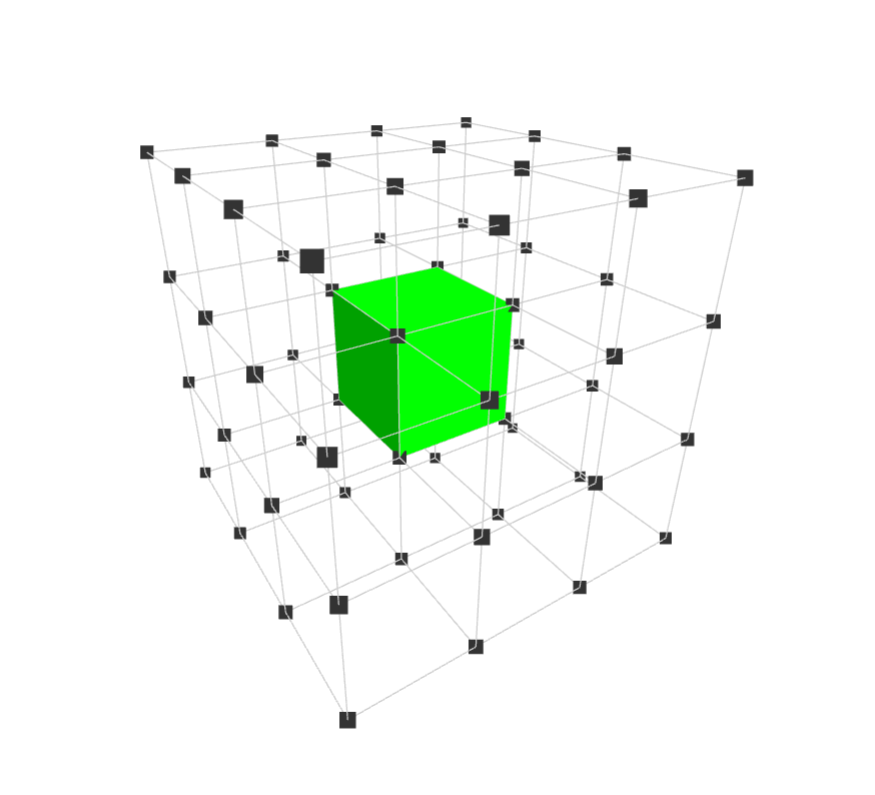

## Define and evaluate a path

In [ ]:
# @title Path and parameters found by AlphaEvolve

best_path_found = np.array([[9.39609406e-01, 9.98329527e-03, -4.07296132e-03, 8.86163961e-02, 5.14178831e-02, 7.89799574e-01], [9.76853949e-01, 8.43900243e-02, -1.87236014e-03, 2.22743402e00, 2.75244655e-02, 5.95653008e-01], [1.01563377e00, 1.58600496e-01, 9.83065911e-05, 4.35572642e00, -9.95231395e-03, 3.63970701e-01], [1.08493385e00, 3.07755287e-01, 4.04501406e-03, 8.62938219e00, -4.35990906e-04, -3.35077274e-01], [1.12726319e00, 4.36994587e-01, 1.65792562e-02, 1.23522097e01, -4.44355561e-01, -1.09977761e00], [1.15035596e00, 5.09864783e-01, 2.46729498e-02, 1.44926365e01, -7.03150883e-01, -1.77573027e00], [1.20020002e00, 6.74818962e-01, 4.13920989e-02, 1.92858257e01, -1.46824802e00, -3.24301616e00], [1.22921833e00, 7.80322440e-01, 5.08392229e-02, 2.23604231e01, -2.05934965e00, -4.19183977e00], [1.25656232e00, 8.86955923e-01, 6.22851979e-02, 2.54006424e01, -2.79233605e00, -4.94301221e00], [1.28161834e00, 9.94185900e-01, 7.13168622e-02, 2.84982429e01, -3.53439006e00, -5.72810662e00], [1.30160821e00, 1.12543063e00, 7.20451855e-02, 3.20688854e01, -3.92805920e00, -5.56488257e00], [1.32438826e00, 1.32927434e00, 7.24034864e-02, 3.77041144e01, -4.47472162e00, -5.17490305e00], [1.33399008e00, 1.48086681e00, 7.58177845e-02, 4.19024902e01, -4.92138226e00, -4.72192269e00], [1.33698854e00, 1.59471234e00, 7.59568220e-02, 4.51249666e01, -5.16592127e00, -4.32429483e00], [1.33554955e00, 1.70831674e00, 7.33949585e-02, 4.84117195e01, -5.24474942e00, -3.95318659e00], [1.33301955e00, 1.77848192e00, 7.30557819e-02, 5.04395679e01, -5.29391038e00, -3.60268508e00], [1.32299384e00, 1.89675169e00, 6.62245210e-02, 5.40094721e01, -5.07170268e00, -3.10511721e00], [1.31609554e00, 1.95530642e00, 6.45580036e-02, 5.57906035e01, -4.95025879e00, -2.75163185e00], [1.29699464e00, 2.06474890e00, 5.28964026e-02, 5.92092384e01, -4.24840518e00, -2.08208301e00], [1.28467533e00, 2.12603596e00, 4.65722033e-02, 6.11978800e01, -3.85394213e00, -1.77381137e00], [1.27612175e00, 2.16246336e00, 4.29218547e-02, 6.23960278e01, -3.60313312e00, -1.60391888e00], [1.25918263e00, 2.22238115e00, 3.52027157e-02, 6.43876548e01, -2.94645508e00, -1.14315788e00], [1.21195969e00, 2.37272154e00, 1.85866337e-02, 6.95501344e01, -1.44731306e00, -3.51817856e-01], [1.17367747e00, 2.46947271e00, 7.87738711e-03, 7.33278162e01, -5.91306950e-01, -2.04315921e-01], [1.13343824e00, 2.56892736e00, 2.40804007e-04, 7.72294036e01, 7.42535282e-02, -1.18797041e-02], [1.10227764e00, 2.63702207e00, -8.13164259e-04, 8.02921591e01, 3.25638556e-01, -9.09491031e-03], [1.08115946e00, 2.67872855e00, -1.94467610e-03, 8.22507337e01, 4.56149966e-01, 9.23364344e-03], [1.06864394e00, 2.70464551e00, -2.09793986e-03, 8.34698923e01, 3.95788406e-01, -2.51260641e-03], [9.93054246e-01, 2.83888423e00, -2.77991124e-03, 9.00331465e01, 6.51004673e-01, -2.00027208e-02], [9.92050998e-01, 3.42584708e00, -2.92617372e-03, 9.00630824e01, 6.48340038e-01, -3.36076805e-02], [9.90524577e-01, 4.81296934e00, -3.78757857e-03, 9.00846127e01, 7.41107384e-01, -4.39029391e-02], [9.88680148e-01, 5.99738121e00, -4.51717463e-03, 9.01046460e01, 8.83485061e-01, -4.10307850e-02], [9.57624286e-01, 5.95289880e00, 1.02741306e-02, 9.01327839e01, 4.19080459e00, 1.12928446e00], [9.42862105e-01, 5.99368058e00, 1.62024942e-02, 9.01288679e01, 5.76538787e00, 1.62560793e00], [9.31969027e-01, 5.99412693e00, 2.06193440e-02, 9.01263482e01, 6.90261077e00, 1.98875845e00], [9.04773557e-01, 6.00941729e00, 3.13747872e-02, 9.01287350e01, 9.61483109e00, 2.83144875e00], [8.85898900e-01, 6.01830162e00, 3.81113604e-02, 9.01359110e01, 1.14508584e01, 3.34953358e00], [8.63540853e-01, 6.02619691e00, 4.48765700e-02, 9.01598001e01, 1.35181743e01, 3.88721021e00], [8.36463078e-01, 6.03765479e00, 5.28267196e-02, 9.01967295e01, 1.59298717e01, 4.48186113e00], [8.04731182e-01, 6.04627379e00, 6.25195903e-02, 9.02336098e01, 1.86990514e01, 5.14505668e00], [7.88296376e-01, 6.05202369e00, 6.75622892e-02, 9.02479959e01, 2.01264906e01, 5.47138803e00], [7.78474876e-01, 6.05538925e00, 7.06050032e-02, 9.02577268e01, 2.09723911e01, 5.66341348e00], [7.70888811e-01, 6.05788046e00, 7.30068444e-02, 9.02657676e01, 2.16229248e01, 5.80874653e00], [7.64648333e-01, 6.05993280e00, 7.49383027e-02, 9.02726388e01, 2.21532161e01, 5.92642676e00], [7.48753549e-01, 6.06467644e00, 8.01606053e-02, 9.02892425e01, 2.34927925e01, 6.21910882e00], [7.37683416e-01, 6.06785126e00, 8.38714978e-02, 9.03001161e01, 2.44180728e01, 6.42046395e00], [7.26094096e-01, 6.07124306e00, 8.79934282e-02, 9.03107738e01, 2.53815663e01, 6.63139700e00], [7.08478913e-01, 6.07645575e00, 9.45805370e-02, 9.03247030e01, 2.68427434e01, 6.95357494e00], [6.85450204e-01, 6.08320452e00, 1.03688262e-01, 9.03410972e01, 2.87527373e01, 7.37124273e00], [6.60511655e-01, 6.09058578e00, 1.14647767e-01, 9.03412970e01, 3.08426719e01, 7.83842912e00], [6.31106763e-01, 6.09898622e00, 1.27562353e-01, 9.03399229e01, 3.32683226e01, 8.35622932e00], [6.02392520e-01, 6.10718508e00, 1.41197449e-01, 9.03187387e01, 3.56585372e01, 8.87446837e00], [5.74685996e-01, 6.11492680e00, 1.54862481e-01, 9.02890178e01, 3.79826280e01, 9.36856002e00], [5.49279838e-01, 6.12170874e00, 1.68073709e-01, 9.02538308e01, 4.01148352e01, 9.81523017e00], [5.23487025e-01, 6.12859076e00, 1.82443691e-01, 9.02080219e01, 4.22797370e01, 1.02799932e01], [4.98121776e-01, 6.13520082e00, 1.97968844e-01, 9.01482985e01, 4.44163048e01, 1.07608292e01], [4.76465121e-01, 6.14082429e00, 2.12016300e-01, 9.00844905e01, 4.62626926e01, 1.11825901e01], [4.56153588e-01, 6.14607051e00, 2.26245551e-01, 9.00101313e01, 4.80125540e01, 1.16017480e01], [4.33791775e-01, 6.15190581e00, 2.43138907e-01, 8.99157178e01, 4.99542210e01, 1.20848160e01], [4.04025852e-01, 6.15902259e00, 2.66186906e-01, 8.97734311e01, 5.25488630e01, 1.27293228e01], [3.66005234e-01, 6.16774759e00, 2.97031124e-01, 8.95738271e01, 5.58931280e01, 1.35723105e01], [3.21312876e-01, 6.17691876e00, 3.35574819e-01, 8.92922705e01, 5.98692011e01, 1.45949530e01], [2.78427663e-01, 6.18417441e00, 3.73123513e-01, 8.89719858e01, 6.37515612e01, 1.55832162e01], [2.39534769e-01, 6.19553929e00, 4.13872182e-01, 8.86402231e01, 6.73322992e01, 1.66327601e01], [2.04472084e-01, 6.19968082e00, 4.64675511e-01, 8.83088859e01, 7.05963626e01, 1.79436724e01], [1.75394931e-01, 6.21048495e00, 5.24148773e-01, 8.80051881e01, 7.33241903e01, 1.94940659e01], [1.53758289e-01, 6.22132345e00, 5.83751542e-01, 8.77681793e01, 7.53731869e01, 2.10578654e01], [1.26442905e-01, 6.23697046e00, 6.75335517e-01, 8.74796317e01, 7.79661162e01, 2.34337293e01], [1.15573630e-01, 6.25005689e00, 7.44980177e-01, 8.73650210e01, 7.90081730e01, 2.52702993e01], [1.06313411e-01, 6.26635361e00, 8.36966776e-01, 8.72610122e01, 7.99079131e01, 2.77208667e01], [9.89070592e-02, 6.27838710e00, 9.12917517e-01, 8.71845804e01, 8.06362714e01, 2.97408798e01], [9.45573652e-02, 6.28550694e00, 9.60719372e-01, 8.71536509e01, 8.10361104e01, 3.10067456e01], [9.02778512e-02, 6.29266034e00, 1.01249647e00, 8.71182294e01, 8.14517010e01, 3.23850431e01], [8.52959027e-02, 6.30150778e00, 1.08113362e00, 8.70519944e01, 8.19245444e01, 3.42396643e01], [8.38752650e-02, 6.30582796e00, 1.11958943e00, 8.69770030e01, 8.21005075e01, 3.53326516e01], [8.25523794e-02, 6.30959352e00, 1.15442156e00, 8.69227818e01, 8.22502751e01, 3.63137560e01], [8.13272459e-02, 6.31280445e00, 1.18563003e00, 8.68893308e01, 8.23738474e01, 3.71785229e01], [7.95266549e-02, 6.31701618e00, 1.22936759e00, 8.68298912e01, 8.25573864e01, 3.84051678e01], [7.60640114e-02, 6.32390774e00, 1.30814197e00, 8.67305760e01, 8.29155599e01, 4.06273839e01], [7.33345584e-02, 6.32845988e00, 1.38417722e00, 8.66469757e01, 8.31880754e01, 4.27737559e01], [7.28754398e-02, 6.33436689e00, 1.51928934e00, 8.59570928e01, 8.33216030e01, 4.72189208e01], [7.40241462e-02, 6.33651625e00, 1.67086132e00, 8.51992673e01, 8.34017941e01, 5.22957490e01], [7.09732742e-02, 6.32973557e00, 1.82119648e00, 8.44273440e01, 8.38384848e01, 5.74161351e01], [6.89950542e-02, 6.32296873e00, 1.89917235e00, 8.41030756e01, 8.40687341e01, 6.00778089e01], [6.54533403e-02, 6.31403661e00, 1.97470221e00, 8.38065972e01, 8.44296311e01, 6.26673579e01], [5.98040781e-02, 6.30238868e00, 2.04639195e00, 8.34821550e01, 8.49583795e01, 6.51956567e01], [5.32315605e-02, 6.28848325e00, 2.11585078e00, 8.31684777e01, 8.55618308e01, 6.77111146e01], [4.67194205e-02, 6.27295621e00, 2.18521241e00, 8.28588875e01, 8.61559337e01, 7.02420111e01], [2.11915399e-02, 6.21382682e00, 2.37163580e00, 8.25672227e01, 8.83741932e01, 7.69350513e01], [1.19033827e-02, 6.16998589e00, 2.48828327e00, 8.37295105e01, 8.91215994e01, 8.03298032e01], [1.14904543e-02, 6.16373556e00, 2.50403291e00, 8.38888370e01, 8.91782177e01, 8.07917836e01], [8.47440903e-03, 6.15720704e00, 2.52053877e00, 8.40621014e01, 8.93189944e01, 8.12648114e01], [5.43451930e-03, 6.12168354e00, 2.60523315e00, 8.49795728e01, 8.97896324e01, 8.37983903e01], [5.00718906e-03, 6.08778028e00, 2.67536568e00, 8.59496099e01, 8.98305811e01, 8.61593636e01], [4.96310192e-03, 6.07475445e00, 2.70089071e00, 8.62819807e01, 8.99205737e01, 8.70030543e01], [4.47449792e-03, 6.05605429e00, 2.73503640e00, 8.67574670e01, 8.98029350e01, 8.81996353e01], [2.97530192e-03, 6.02087628e00, 2.79766649e00, 8.74594750e01, 9.01346094e01, 9.05955514e01], [9.53058079e-04, 5.99709120e00, 2.84427868e00, 8.76265515e01, 9.02788300e01, 9.23854717e01], [-2.31375478e-03, 5.99154793e00, 4.38250817e00, 8.73674843e01, 9.06652632e01, 9.27094979e01]], dtype=np.float64)

# We have set grid_fineness to 0.05 so that you can quickly visualize the sofa.
# If you want to verify the volume = 1.81 result in the paper, change
# grid_fineness to 0.002 here then run the next cell, which takes ~4 hours to
# compute on a T4 GPU runtime.
grid_fineness = 0.05

translation_tol = 0.05
rotation_tol = 1

In [ ]:
# @title Calculate surviving sofa points

# When run with grid_fineness = 0.002, this cell verifies the volume = 1.81
# result from the paper in ~4 hours on a T4 GPU runtime.

# Running with larger values of grid_fineness produces faster results that you
# can use for visualisations, but the volume calculations are less precise.

print('Computing surviving sofa points...')
point_survival_mask, volume = (
    generate_sofa_and_evaluate_path(
        best_path_found,
        grid_fineness=grid_fineness,
        translation_tol=translation_tol,
        rotation_tol=rotation_tol,
    )
)

# Get sofa_points from point_survival_mask
initial_points_generator, _, _ = generate_initial_sofa_points_in_batches(grid_fineness)
sofa_points = []
pointer = 0
for initial_points_batch in initial_points_generator():
  sofa_points_batch = initial_points_batch[point_survival_mask[pointer : pointer + len(initial_points_batch)]]
  pointer += len(initial_points_batch)
  sofa_points.append(sofa_points_batch)
sofa_points = np.concatenate(sofa_points)
print(f'{sofa_points.shape=}')

## Visualisations

In [ ]:
# @title Helper functions

def subsample(arr: np.ndarray, max_samples: int) -> np.ndarray:
  """Randomly subsamples up to max_samples from first dim of arr."""
  N = arr.shape[0]
  if N <= max_samples:
    return arr
  sampled_indices = np.random.choice(N, max_samples, replace=False)
  sampled_indices.sort()
  return arr[sampled_indices]


def set_view(ax, view='isometric'):
  """Set camera view based on the 'view' parameter."""
  if view == 'y':
    ax.view_init(elev=0, azim=-90)  # Looking down X, Y-Z plane
  elif view == 'x':
    ax.view_init(elev=0, azim=0)  # Looking down Y, X-Z plane
  elif view == 'z':
    ax.view_init(elev=90, azim=-90)  # Looking down Z, X-Y plane
  elif view == 'isometric':
    # Default view or a more general 3D perspective
    ax.view_init(elev=30, azim=-60)  # Isometric view
  else:
    raise ValueError(f'Invalid {view=}. Must be x, y, z, or isometric.')


def ExtractHtml(result):
  html_text = ''
  for output in result.outputs:
    if 'text/html' in output.data:
      html_text += output.data['text/html']
    if 'application/javascript' in output.data:
      html_text += (
          '<script>' + output.data['application/javascript'] + '</script>'
      )
  return html_text


def display_animation(ani):
  with IPython.utils.capture.capture_output() as result:
    display(HTML(ani.to_jshtml()))
    html_output = ExtractHtml(result)
  display(HTML(html_output))

In [ ]:
# @title Static 2D sofa projection

def plot_sofa_projection_2d(sofa_points, axis='z'):
  """Generates a static 2D plot of the sofa points projected onto a specified plane.

  Args:
      sofa_points: Nx3 array of points defining the sofa shape.
      axis: The axis to look "down" on ('x', 'y', or 'z'). Determines the
        projection plane (e.g., 'z' projects onto x-y).
  """
  fig, ax = plt.subplots(figsize=(4,4))  # Create figure and axes

  if axis == 'z':  # Project onto x-y plane
    ax.scatter(sofa_points[:, 0], sofa_points[:, 1], s=0.1, alpha=0.5)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Sofa Projection (X-Y Plane)')
  elif axis == 'y':  # Project onto x-z plane
    ax.scatter(sofa_points[:, 0], sofa_points[:, 2], s=0.1, alpha=0.5)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Z-axis')
    ax.set_title('Sofa Projection (X-Z Plane)')
  elif axis == 'x':  # Project onto y-z plane
    ax.scatter(sofa_points[:, 1], sofa_points[:, 2], s=0.1, alpha=0.5)
    ax.set_xlabel('Y-axis')
    ax.set_ylabel('Z-axis')
    ax.set_title('Sofa Projection (Y-Z Plane)')
  else:
    raise ValueError(f'{axis=} must be "x", "y" or "z".')

  ax.axis('equal')  # Ensure equal scaling for axes
  ax.grid(True)
  plt.show()


for view in ['x', 'y', 'z']:
  plot_sofa_projection_2d(sofa_points, axis=view)

In [ ]:
# @title 3D rotating sofa animation

def animate_sofa_rotation(
    sofa_points,
    view='isometric',
    rotation_axis='x',
    max_points=15_000,
    num_frames=20,
    interval=50,
):
  """Displays an animation of the sofa rotating in place.

  Args:
    sofa_points: Nx3 array of points defining the sofa shape.
    view: Specifies the viewing perspective ('x', 'y', 'z', or 'isometric').
    rotation_axis: Specifies the rotation axis/axes ('x', 'y', or 'z').
    max_points: Number of sofa points to use in the animation.
    num_frames: Number of frames for the rotation animation.
    interval: Delay between frames in milliseconds.
  """
  # Subsample if needed for rotation animation performance
  orig_num_sofa_points = len(sofa_points)
  sofa_points = subsample(sofa_points, max_points)
  print(
      f'Using {len(sofa_points)=:_} sofa points (subsampled from'
      f' {orig_num_sofa_points=:_})'
  )

  # Center the sofa points around the origin for rotation
  center = np.mean(sofa_points, axis=0)
  points_centered = sofa_points - center

  # Init figure
  title = f'Sofa Rotation ({rotation_axis=}, {view=})'
  fig_rot = plt.figure(figsize=(6, 6))
  ax_rot = fig_rot.add_subplot(111, projection='3d')
  ax_rot.set_title(title)
  ax_rot.set_box_aspect([1, 1, 1])  # make aspect ratio equal
  ax_rot.set_xlabel('X')
  ax_rot.set_ylabel('Y')
  ax_rot.set_zlabel('Z')
  set_view(ax_rot, view)
  scatter_rot = None  # Initialize scatter object reference

  # Determine plot limits based on centered points
  max_range = (
      np.ptp(points_centered, axis=0).max() * 0.6
  )  # Peak-to-peak range * padding
  ax_rot.set_xlim(-max_range, max_range)
  ax_rot.set_ylim(-max_range, max_range)
  ax_rot.set_zlim(-max_range, max_range)

  # --- Define Rotation ---
  total_rotation_angle = 2 * np.pi

  def get_rotation_matrix(axis, angle):
    """Get rotation matrix for specified axis and angle (radians)."""
    c, s = np.cos(angle), np.sin(angle)
    if axis == 'x':
      return np.array([[1, 0, 0], [0, c, -s], [0, s, c]])
    elif axis == 'y':
      return np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]])
    elif axis == 'z':
      return np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
    else:
      raise ValueError(f'Wrong {axis=}')

  def init_rot():
    nonlocal scatter_rot
    scatter_rot = ax_rot.scatter(
        [], [], [], s=5, alpha=0.1, color='blue', depthshade=False
    )
    ax_rot.set_title(f'{title} - Frame 0')
    return [scatter_rot]  # Return the (currently empty) scatter object

  def update_rot(frame):
    nonlocal scatter_rot
    angle = (frame / num_frames) * total_rotation_angle
    if rotation_axis == 'x':
      R_combined = get_rotation_matrix('x', angle)
    elif rotation_axis == 'y':
      R_combined = get_rotation_matrix('y', angle)
    elif rotation_axis == 'z':
      R_combined = get_rotation_matrix('z', angle)
    else:
      raise ValueError(f'Invalid {rotation_axis=}.')

    # Apply rotation to the *original centered* points
    rotated_points = points_centered @ R_combined.T

    # Update scatter data and return
    scatter_rot._offsets3d = (
        rotated_points[:, 0],
        rotated_points[:, 1],
        rotated_points[:, 2],
    )
    ax_rot.set_title(f'{title} - Frame {frame}')
    return [scatter_rot]

  # Create Rotation Animation
  ani = FuncAnimation(
      fig_rot,
      update_rot,
      frames=num_frames,
      init_func=init_rot,
      blit=True,
      interval=interval,
      repeat=True,
  )
  plt.close(fig_rot)
  display_animation(ani)


ani = animate_sofa_rotation(
    sofa_points,
    max_points=15_000,
    num_frames=100,
    view='isometric',
    rotation_axis='x',
)

In [ ]:
# @title Another 3D rotation

def _animate_sofa_rotation(sofa_points,
                          title="Sofa Rotation",
                          num_frames_rot=50,
                          total_num_rotations=1,
                          interval=100,
                          alpha=0.1,
                          rotation_axis='yz', # Added rotation_axis parameter
                          view='all'): # Added view parameter
    """
    Creates and displays an animation of the sofa rotating in place.
    Optionally saves the HTML output to a CNS path.

    Args:
        sofa_points (np.ndarray): Nx3 array of points defining the sofa shape.
        title (str): Title for the animation plot.
        num_frames_rot (int): Number of frames for the rotation animation.
        total_num_rotations (float): Number of full 360-degree rotations.
        interval (int): Delay between frames in milliseconds.
        rotation_axis (str): Specifies the rotation axis/axes ('x', 'y', 'z', or 'yz').
        view (str): Specifies the viewing perspective ('x', 'y', 'z', or 'all').
    """
    if not isinstance(sofa_points, np.ndarray):
      raise ValueError('sofa_points must be a numpy array')
    if sofa_points.ndim != 2 or sofa_points.shape[1] != 3:
      raise ValueError(f'sofa_points has wrong shape: {sofa_points.shape}')
    if sofa_points.shape[0] == 0:
      print("No sofa points provided for rotation animation.")
      return # Exit if no points
    if rotation_axis not in ['x', 'y', 'z', 'yz']:
        print(f"Warning: Invalid rotation_axis '{rotation_axis}'. Using 'yz' default.")
        rotation_axis = 'yz'
    if view not in ['x', 'y', 'z', 'all']:
        print(f"Warning: Invalid view '{view}'. Using 'all' default.")
        view = 'all'


    print(f"\n--- Creating Sofa Rotation Animation ({sofa_points.shape[0]} points) ---")

    # Center the sofa points around the origin for rotation
    center = np.mean(sofa_points, axis=0)
    points_centered = sofa_points - center

    # Init figure
    fig_rot = plt.figure(figsize=(8, 8))
    ax_rot = fig_rot.add_subplot(111, projection='3d')
    scatter_rot = None # Initialize scatter object reference

    # Title
    title += f' ({rotation_axis=}, {view=})'

    # Determine plot limits based on centered points
    max_range = np.ptp(points_centered, axis=0).max() * 0.6 # Peak-to-peak range * padding
    ax_rot.set_xlim(-max_range, max_range)
    ax_rot.set_ylim(-max_range, max_range)
    ax_rot.set_zlim(-max_range, max_range)
    ax_rot.set_xlabel("X")
    ax_rot.set_ylabel("Y")
    ax_rot.set_zlabel("Z")

    # Set camera view based on the 'view' parameter
    set_view(ax_rot, view)
    ax_rot.set_title(title)

    # Try to make aspect ratio equal
    ax_rot.set_box_aspect([1,1,1]) # For matplotlib 3.3+

    # --- Define Rotation ---
    total_rotation_angle = total_num_rotations * 2 * np.pi

    def get_rotation_matrix(axis, angle):
        """ Get rotation matrix for specified axis and angle (radians). """
        c, s = np.cos(angle), np.sin(angle)
        if axis == 'x':
            return np.array([[1, 0, 0], [0, c, -s], [0, s, c]])
        elif axis == 'y':
            return np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]])
        elif axis == 'z':
            return np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
        else:
            return np.identity(3)

    def init_rot():
        nonlocal scatter_rot # Allow modification of outer scope variable
        # print("Init rotation animation...") # Suppress verbose output
        # CREATE the scatter object BUT with NO data initially.
        # Blitting requires the object exists, but it shouldn't draw anything yet.
        scatter_rot = ax_rot.scatter([], [], [], # <-- Use empty lists/arrays
                                     s=5, alpha=alpha, color='blue', depthshade=False)
        # Set the title for frame 0. The first update call will draw the points.
        ax_rot.set_title(f"{title} - Frame 0")
        # Return the (currently empty) scatter object. It's needed for blitting.
        return [scatter_rot]

    def update_rot(frame):
        nonlocal scatter_rot
        angle = (frame / num_frames_rot) * total_rotation_angle
        R_combined = np.identity(3) # Start with identity matrix

        if rotation_axis == 'x':
            R_combined = get_rotation_matrix('x', angle)
        elif rotation_axis == 'y':
            R_combined = get_rotation_matrix('y', angle)
        elif rotation_axis == 'z':
            R_combined = get_rotation_matrix('z', angle)
        elif rotation_axis == 'yz':
            # Original behavior: Rotate around Z then Y
            z_rotation_speed = 0.9
            y_rotation_speed = 1.1
            angle_z = angle * z_rotation_speed
            angle_y = angle * y_rotation_speed
            Rz = get_rotation_matrix('z', angle_z)
            Ry = get_rotation_matrix('y', angle_y)
            R_combined = Ry @ Rz # Combine rotations (apply Z then Y)


        # Apply rotation to the *original centered* points
        rotated_points = points_centered @ R_combined.T # Note the transpose

        # Update scatter data (efficient way for 3D)
        scatter_rot._offsets3d = (rotated_points[:, 0], rotated_points[:, 1], rotated_points[:, 2])
        ax_rot.set_title(f"{title} - Frame {frame}")

        return [scatter_rot]

    # --- Create and Display/Save Rotation Animation ---
    print("Creating rotation FuncAnimation object...")
    # Use %%capture to capture the HTML output
    with IPython.utils.capture.capture_output() as result:
        ani_rot = FuncAnimation(fig_rot, update_rot, frames=num_frames_rot,
                                init_func=init_rot, blit=True, interval=interval, repeat=True) # blit=True if possible
        # Display the animation within the captured block
        display(HTML(ani_rot.to_jshtml()))

    print("Rotation FuncAnimation object created.")


    # Close the plot figure
    plt.close(fig_rot)

    # Process captured output
    html_output_rot = ExtractHtml(result)

    # Display the captured HTML
    print("Displaying rotation animation...")
    display(HTML(html_output_rot))
    print("Rotation animation should be displayed above.")


def animate_sofa_rotation(sofa_points, **kwargs):

  # Subsample if needed for rotation animation performance
  max_rot_points = 15_000
  print(f"Possibly subsampling points for rotation animation from {len(sofa_points):_} to {max_rot_points:_}...")
  points_for_rot_anim = subsample(sofa_points, max_rot_points)
  print(f"Got {len(points_for_rot_anim)=:_}")

  # --- Call the animation function ---
  _animate_sofa_rotation(
      points_for_rot_anim,
      **kwargs,
      )

animate_sofa_rotation(sofa_points, num_frames_rot=100, view='x', rotation_axis='y', interval=50)

In [ ]:
# @title Animated cross-section with moving cutting plane


def _setup_2d_panel(ax_2d, xlabel_2d, ylabel_2d, sofa_points, proj_indices_2d):
  """Setup the 2D panel that shows the current cross-section."""
  ax_2d.clear()

  # Set 2D plot limits based on the full range of projected points
  xlims_2d = (
      np.min(sofa_points[:, proj_indices_2d[0]]),
      np.max(sofa_points[:, proj_indices_2d[0]]),
  )
  ylims_2d = (
      np.min(sofa_points[:, proj_indices_2d[1]]),
      np.max(sofa_points[:, proj_indices_2d[1]]),
  )
  x_range_2d = xlims_2d[1] - xlims_2d[0]
  y_range_2d = ylims_2d[1] - ylims_2d[0]
  xcentre_2d = (xlims_2d[0] + xlims_2d[1]) / 2
  ycentre_2d = (ylims_2d[0] + ylims_2d[1]) / 2
  if x_range_2d > y_range_2d:
    ylims_2d = (ycentre_2d - x_range_2d / 2, ycentre_2d + x_range_2d / 2)
  else:
    xlims_2d = (xcentre_2d - y_range_2d / 2, xcentre_2d + y_range_2d / 2)

  scatter_2d = ax_2d.scatter([], [], s=0.1, alpha=0.5)
  ax_2d.set_xlabel(xlabel_2d)
  ax_2d.set_ylabel(ylabel_2d)
  ax_2d.set_title(f'Sofa Cross-Section ({xlabel_2d}-{ylabel_2d} plane)')
  ax_2d.axis('equal')
  ax_2d.grid(True)
  ax_2d.set_xlim(xlims_2d)
  ax_2d.set_ylim(ylims_2d)
  corner_points_2d = np.array([
      [xlims_2d[0], ylims_2d[0]],
      [xlims_2d[1], ylims_2d[0]],
      [xlims_2d[1], ylims_2d[1]],
      [xlims_2d[0], ylims_2d[1]],
  ])
  return ax_2d, scatter_2d, corner_points_2d


def _update_2d_panel(
    ax_2d,
    xlabel_2d,
    ylabel_2d,
    proj_indices_2d,
    section_val,
    axis,
    axis_index,
    min_val,
    max_val,
    num_frames,
    corner_points_2d,
    scatter_2d,
    corner_colors,
    frame,
):
  """Update the 2D panel that shows the current cross-section."""
  tolerance = (max_val - min_val) / (num_frames * 2)  # Half the step size
  mask_2d = (sofa_points[:, axis_index] >= section_val - tolerance) & (
      sofa_points[:, axis_index] < section_val + tolerance
  )
  section_points_2d = sofa_points[mask_2d]
  scatter_2d.set_offsets(section_points_2d[:, proj_indices_2d])
  for i, (x, y) in enumerate(corner_points_2d):
    ax_2d.plot(x, y, 'o', color=corner_colors[i], markersize=10)
  ax_2d.set_title(
      'Sofa Cross-Section'
      f' ({xlabel_2d}-{ylabel_2d} plane)\n{axis}={section_val:.4f} ({frame+1}/{num_frames})'
  )
  return ax_2d, corner_points_2d, scatter_2d


def _setup_3d_panel(ax_3d, sofa_points_subsampled, view, corner_colors):
  """Setup the 3D panel that shows the cutting plane in the 3D sofa."""
  ax_3d.clear()

  # Set plot limits based on the full range of sofa points
  max_range_3d = (
      np.ptp(sofa_points_subsampled, axis=0).max() * 0.6
  )  # Peak-to-peak range * padding
  center_3d = np.mean(sofa_points_subsampled, axis=0)
  ax_3d.set_xlim(center_3d[0] - max_range_3d, center_3d[0] + max_range_3d)
  ax_3d.set_ylim(center_3d[1] - max_range_3d, center_3d[1] + max_range_3d)
  ax_3d.set_zlim(center_3d[2] - max_range_3d, center_3d[2] + max_range_3d)
  ax_3d.set_xlabel('X')
  ax_3d.set_ylabel('Y')
  ax_3d.set_zlabel('Z')
  ax_3d.set_title('3D Sofa with Cutting Plane')
  ax_3d.set_box_aspect([1, 1, 1])  # Equal aspect ratio
  set_view(ax_3d, view)

  # Initialize scatter objects for points before and after the plane
  scatter_before = ax_3d.scatter([], [], [], s=5, alpha=0.1, color='purple')
  scatter_after = ax_3d.scatter([], [], [], s=5, alpha=0.1, color='blue')

  # Initialize scatter objects for the corner dots in 3D
  scatter_corners_3d = [
      ax_3d.scatter([], [], [], color=c, marker='o', s=100)
      for c in corner_colors
  ]

  return ax_3d, scatter_before, scatter_after, scatter_corners_3d


def _update_3d_panel(
    ax_3d,
    axis,
    section_val,
    update,
    scatter_corners_3d,
    sofa_points_subsampled,
    axis_index,
    scatter_before,
    scatter_after,
):
  """Update the 3D panel that shows the cutting plane in the 3D sofa."""
  # Remove the previous plane artist if it exists
  if hasattr(update, 'plane') and update.plane is not None:
    update.plane.remove()
    update.plane = None  # Reset plane to None after removing

  # Draw the plane and its corner points at section_val
  update.plane, corner_plane_points = _get_cutting_plane_and_corners(
      ax_3d, axis, section_val
  )
  for i, (x, y, z) in enumerate(corner_plane_points):
    scatter_corners_3d[i]._offsets3d = ([x], [y], [z])

  # Plot points before (purple) and after (blue) the plane
  mask_before = sofa_points_subsampled[:, axis_index] < section_val
  mask_after = sofa_points_subsampled[:, axis_index] >= section_val
  points_before = sofa_points_subsampled[mask_before]
  points_after = sofa_points_subsampled[mask_after]
  scatter_before._offsets3d = (
      points_before[:, 0],
      points_before[:, 1],
      points_before[:, 2],
  )
  scatter_after._offsets3d = (
      points_after[:, 0],
      points_after[:, 1],
      points_after[:, 2],
  )

  ax_3d.set_title(f'3D Sofa with Cutting Plane\n{axis}={section_val:.4f}')

  return scatter_before, scatter_after, scatter_corners_3d, update


def _get_cutting_plane_and_corners(ax_3d, axis, section_val):
  """Get the cutting plane and its corners, where axis is equal to section_val."""
  (x_min, x_max), (y_min, y_max), (z_min, z_max) = (
      ax_3d.get_xlim(),
      ax_3d.get_ylim(),
      ax_3d.get_zlim(),
  )
  x_linspace = np.linspace(x_min, x_max, 10)
  y_linspace = np.linspace(y_min, y_max, 10)
  z_linspace = np.linspace(z_min, z_max, 10)
  if axis == 'x':
    Y, Z = np.meshgrid(y_linspace, z_linspace)
    X = np.full_like(Y, section_val)
    corner_points = np.array([
        [section_val, y_min, z_min],
        [section_val, y_max, z_min],
        [section_val, y_max, z_max],
        [section_val, y_min, z_max],
    ])
  elif axis == 'y':
    X, Z = np.meshgrid(x_linspace, z_linspace)
    Y = np.full_like(X, section_val)
    corner_points = np.array([
        [x_min, section_val, z_min],
        [x_max, section_val, z_min],
        [x_max, section_val, z_max],
        [x_min, section_val, z_max],
    ])
  elif axis == 'z':
    X, Y = np.meshgrid(x_linspace, y_linspace)
    Z = np.full_like(X, section_val)
    corner_points = np.array([
        [x_min, y_min, section_val],
        [x_max, y_min, section_val],
        [x_max, y_max, section_val],
        [x_min, y_max, section_val],
    ])
  else:
    raise ValueError(f'Invalid axis {axis=}.')
  plane = ax_3d.plot_surface(
      X, Y, Z, color='red', alpha=0.4, rstride=1, cstride=1
  )
  return plane, corner_points


def _projection_indices_and_labels(axis):
  """Determine the projection plane, indices, and labels based on the axis"""
  if axis == 'x':
    axis_index = 0
    proj_indices_2d = (1, 2)  # Project onto y-z plane for 2D
    xlabel_2d, ylabel_2d = 'y', 'z'
  elif axis == 'y':
    axis_index = 1
    proj_indices_2d = (0, 2)  # Project onto x-z plane for 2D
    xlabel_2d, ylabel_2d = 'x', 'z'
  elif axis == 'z':
    axis_index = 2
    proj_indices_2d = (0, 1)  # Project onto x-y plane for 2D
    xlabel_2d, ylabel_2d = 'x', 'y'
  else:
    raise ValueError(f"Invalid axis '{axis}'. Please use 'x', 'y', or 'z'.")
  return axis_index, proj_indices_2d, xlabel_2d, ylabel_2d


def animate_sofa_cross_section(
    sofa_points,
    view='isometric',
    axis='z',
    num_frames=20,
    max_3d_points=15_000,
    interval=100,
):
  """Displays an animation with two panels: a 2D cross-section and a simultaneous
  3D visualization with a moving plane.

  Args:
      sofa_points (np.ndarray): Nx3 array of points defining the sofa shape.
      view: viewpoint of the 3d visualization: x, y, z or isometric.
      axis (str): The axis along which to take cross-sections and move the plane
        ('x', 'y', or 'z').
      num_frames (int): The number of frames in the animation.
      max_3d_points: max number of sofa points to visualize in the 3d animation.
      interval (int): The delay between frames in milliseconds.
  """
  # Subsample points for 3D visualization if necessary (for performance)
  sofa_points_subsampled = subsample(sofa_points, max_3d_points)
  print(
      f'Using {len(sofa_points_subsampled):_} sofa points for 3D animation'
      f' (subsampled from {len(sofa_points)=:_}).'
  )

  # Get indices and labels for the 2D projection.
  axis_index, proj_indices_2d, xlabel_2d, ylabel_2d = (
      _projection_indices_and_labels(axis)
  )

  # Determine the range of the chosen axis for cross-sections and plane movement
  min_val, max_val = np.min(sofa_points[:, axis_index]), np.max(
      sofa_points[:, axis_index]
  )
  section_values = np.linspace(min_val, max_val, num_frames)

  # Setup the figure and axes for two panels
  fig = plt.figure(figsize=(12, 6))  # Wide figure for two plots
  ax_2d = fig.add_subplot(121)  # 1 row, 2 columns, 1st plot (left)
  ax_3d = fig.add_subplot(
      122, projection='3d'
  )  # 1 row, 2 columns, 2nd plot (right)

  # Initialize scatter objects here so they are accessible in both init and update
  scatter_2d = None
  scatter_before = None
  scatter_after = None
  scatter_corners_3d = None
  corner_points_2d = None
  corner_colors = ['black', 'lime', 'deeppink', 'orange']

  def init():
    """Animation init fn"""
    nonlocal ax_2d, ax_3d, scatter_2d, scatter_before, scatter_after, scatter_corners_3d, corner_points_2d  # Declare axes and scatter objects as nonlocal

    # Setup axes properties (labels, titles, limits) for both panels.
    ax_2d, scatter_2d, corner_points_2d = _setup_2d_panel(
        ax_2d, xlabel_2d, ylabel_2d, sofa_points, proj_indices_2d
    )
    ax_3d, scatter_before, scatter_after, scatter_corners_3d = _setup_3d_panel(
        ax_3d, sofa_points_subsampled, view, corner_colors
    )

    # Return all artists that will be updated
    # The plane will be created in the first update call, so it's not returned here.
    return [scatter_2d, scatter_before, scatter_after] + scatter_corners_3d

  def update(frame):
    """Animation update fn"""
    nonlocal ax_2d, scatter_2d, scatter_before, scatter_after, scatter_corners_3d, corner_points_2d, update  # Declare scatter objects as nonlocal

    section_val = section_values[frame]

    # Update both panels.
    ax_2d, corner_points_2d, scatter_2d = _update_2d_panel(
        ax_2d,
        xlabel_2d,
        ylabel_2d,
        proj_indices_2d,
        section_val,
        axis,
        axis_index,
        min_val,
        max_val,
        num_frames,
        corner_points_2d,
        scatter_2d,
        corner_colors,
        frame,
    )
    scatter_before, scatter_after, scatter_corners_3d, update = (
        _update_3d_panel(
            ax_3d,
            axis,
            section_val,
            update,
            scatter_corners_3d,
            sofa_points_subsampled,
            axis_index,
            scatter_before,
            scatter_after,
        )
    )

    # Return all artists that were updated or created
    return (
        [scatter_2d, scatter_before, scatter_after]
        + scatter_corners_3d
        + [update.plane]
    )

  # Create and Display Animation
  with IPython.utils.capture.capture_output() as result:
    ani = FuncAnimation(
        fig,
        update,
        frames=num_frames,
        init_func=init,
        blit=True,
        interval=interval,
        repeat=False,
    )  # blit=True
    display(HTML(ani.to_jshtml()))
  plt.close(fig)
  display_animation(ani)


animate_sofa_cross_section(
    sofa_points, axis='x', view='isometric', max_3d_points=15_000, num_frames=20
)

In [ ]:
# @title 3D sofa corridor path animation

def get_corridor_segments_for_plotting() -> (
    list[tuple[list[float], list[float], str, str]]
):
  """Returns bounds and colors for plotting the *visual representation* of the corridor segments."""
  w = CORRIDOR_WIDTH
  VISUAL_EXTENT = 9.0  # How far to draw the first and third segments

  segments = [
      # First segment (X direction)
      ([-VISUAL_EXTENT, 0, 0], [0, w, w], 'blue', '-'),
      # Second segment (Y direction)
      ([0, 0, 0], [w, MIDDLE_LENGTH + w, w], 'red', '-'),
      # Third segment (Z direction)
      (
          [0, MIDDLE_LENGTH + w, 0],
          [w, MIDDLE_LENGTH + (2 * w), VISUAL_EXTENT],
          'green',
          '-',
      ),
  ]
  return segments

def _plot_cuboid_edges(ax, mins, maxs, color='grey', linestyle='-', alpha=0.4):
  """Plot the edges of a cuboid with sides given by mins and maxs."""
  x_min, y_min, z_min = mins
  x_max, y_max, z_max = maxs

  # Get the coordinates of the 8 corners.
  corners = np.array([
      [x_min, y_min, z_min],
      [x_max, y_min, z_min],
      [x_max, y_max, z_min],
      [x_min, y_max, z_min],
      [x_min, y_min, z_max],
      [x_max, y_min, z_max],
      [x_max, y_max, z_max],
      [x_min, y_max, z_max],
  ])  # shape (8, 3)

  # Get the 12 edges (between corner indexes 0 to 7).
  edges = [
      (0, 1),
      (1, 2),
      (2, 3),
      (3, 0),
      (4, 5),
      (5, 6),
      (6, 7),
      (7, 4),
      (0, 4),
      (1, 5),
      (2, 6),
      (3, 7),
  ]

  # Plot each edge
  for i, j in edges:
    two_corners = corners[[i, j], :]  # shape (2, 3)
    ax.plot(
        two_corners[:, 0],
        two_corners[:, 1],
        two_corners[:, 2],
        color=color,
        linestyle=linestyle,
        alpha=alpha,
    )


def _plot_sofa(ax, sofa_points, color='blue'):
  """Plot sofa_points on ax."""
  return ax.scatter(
      sofa_points[:, 0],
      sofa_points[:, 1],
      sofa_points[:, 2],
      s=0.5,
      alpha=0.1,
      color=color,
      depthshade=False,
  )


def animate_sofa_corridor_path(
    sofa_points,
    path,
    view='isometric',
    max_frames=20,
    max_sofa_points=10_000,
):
  """Displays a moving 3d animation of the sofa's path through the corridor."""
  plt.close()

  # Subsample sofa_points to max_sofa_points
  orig_sofa_points = len(sofa_points)
  sofa_points = subsample(sofa_points, max_sofa_points)
  print(
      f'Using {len(sofa_points)=:_} sofa points (subsampled from'
      f' {orig_sofa_points=:_})'
  )

  # Subsample path to max number of animation frames
  orig_path_length = len(path)
  path = subsample(path, max_frames)
  print(
      f'Using {len(path)=:_} path points (subsampled from'
      f' {orig_path_length=:_})'
  )

  # Get translation and rotation matrices from path
  translations = path[:, :3]  # (num_steps, 3)
  angles_deg = path[:, 3:]  # (num_steps, 3)
  rotation = transform.Rotation.from_euler('zyx', angles_deg, degrees=True)
  rotation_matrices = jnp.array(rotation.as_matrix())  # (num_steps, 3, 3)

  # Setup plot
  fig = plt.figure(figsize=(6, 6))
  ax = fig.add_subplot(111, projection='3d')
  set_view(ax, view)
  ax.set_box_aspect([1, 1, 1])  # make aspect ratio equal
  sofa_scatter = None  # init global

  def init():
    """Animation initialisation function."""
    global sofa_scatter  # Declare global for assignment
    ax.clear()
    sofa_scatter = None  # Ensure it starts as None

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(
        f'Frame {0}/{len(path)},'
        f' {view=}\n{np.array_str(path[0], precision=2, suppress_small=True)}'
    )

    # Plot corridor
    plot_segments = get_corridor_segments_for_plotting()
    for mins, maxs, color, linestyle in plot_segments:
      _plot_cuboid_edges(
          ax, mins, maxs, color=color, alpha=0.3, linestyle=linestyle
      )

    # Plot frame 0 position of the sofa points and return.
    transformed_points0 = transform_points(
        sofa_points, rotation_matrices[0], translations[0]
    )
    sofa_scatter = _plot_sofa(ax, transformed_points0)
    return [sofa_scatter]

  def update(frame):
    """Animation update function."""
    global sofa_scatter
    if frame % 10 == 0:
      print(f'Update {frame}/{len(path)}')
    ax.set_title(
        f'Frame {frame}/{len(path)},'
        f' {view=}\n{np.array_str(path[frame], precision=2, suppress_small=True)}'
    )
    if sofa_scatter:
      sofa_scatter.remove()
    transformed_points = transform_points(
        sofa_points, rotation_matrices[frame], translations[frame]
    )
    sofa_scatter = _plot_sofa(ax, transformed_points)
    return [sofa_scatter]

  # Create animation and return.
  ani = FuncAnimation(
      fig,
      update,
      frames=range(len(path)),
      init_func=init,
      blit=False,
      interval=60,
      repeat=False,
  )
  plt.close(fig)
  display_animation(ani)


# Smooth the path
print(f'Input path: {best_path_found.shape=}')
smoothed_path = add_start_and_end_poses(best_path_found)
smoothed_path = smooth_path_to_tolerances(
    smoothed_path, translation_tol, rotation_tol
)
print(
    f'Smoothed path: {smoothed_path.shape=} with {translation_tol=},'
    f' {rotation_tol=}'
)

animate_sofa_corridor_path(
    sofa_points, smoothed_path, view='isometric', max_frames=20, max_sofa_points=10_000
)

In [ ]:
#@title Views from different angles

import numpy as np
import matplotlib.pyplot as plt

# --- Helper function to create the 3D sofa points ---
def create_sofa_points():
    """Generates the 3D point cloud for the sofa."""
    x_base=np.linspace(0,2,20);y_base=np.linspace(0,0.8,8);z_base=np.linspace(0,0.4,4)
    xx_base,yy_base,zz_base=np.meshgrid(x_base,y_base,z_base)
    base_points=np.vstack([xx_base.ravel(),yy_base.ravel(),zz_base.ravel()]).T
    x_back=np.linspace(0,2,20);y_back=np.linspace(0,0.2,2);z_back=np.linspace(0.4,1,6)
    xx_back,yy_back,zz_back=np.meshgrid(x_back,y_back,z_back)
    back_points=np.vstack([xx_back.ravel(),yy_back.ravel(),zz_back.ravel()]).T
    x_arm1=np.linspace(0,0.2,2);y_arm1=np.linspace(0,0.8,8);z_arm1=np.linspace(0.4,0.7,3)
    xx_arm1,yy_arm1,zz_arm1=np.meshgrid(x_arm1,y_arm1,z_arm1)
    arm1_points=np.vstack([xx_arm1.ravel(),yy_arm1.ravel(),zz_arm1.ravel()]).T
    x_arm2=np.linspace(1.8,2,2);y_arm2=np.linspace(0,0.8,8);z_arm2=np.linspace(0.4,0.7,3)
    xx_arm2,yy_arm2,zz_arm2=np.meshgrid(x_arm2,y_arm2,z_arm2)
    arm2_points=np.vstack([xx_arm2.ravel(),yy_arm2.ravel(),zz_arm2.ravel()]).T
    x_cush=np.linspace(0.3,0.8,10);y_cush=np.linspace(0.2,0.7,10);z_cush=np.linspace(0.4,0.5,2)
    xx_c,yy_c,zz_c=np.meshgrid(x_cush,y_cush,z_cush)
    cushion_points=np.vstack([xx_c.ravel(),yy_c.ravel(),zz_c.ravel()]).T
    return np.vstack([base_points,back_points,arm1_points,arm2_points,cushion_points])

def get_visible_points_for_direction(points, view_direction, resolution=150):
    """
    Filters a point cloud to show only the points visible from an arbitrary direction.
    """
    # 1. Create an orthonormal basis (a new coordinate system) from the view direction
    # The view_direction is our new z-axis
    z_new = view_direction / np.linalg.norm(view_direction)

    # Create a temporary vector that is not parallel to z_new
    temp_vec = np.array([0, 0, 1])
    if np.allclose(np.abs(np.dot(z_new, temp_vec)), 1.0):
        temp_vec = np.array([0, 1, 0]) # Use y-axis if z_new is vertical

    # The new x-axis is perpendicular to both z_new and the temp vector
    x_new = np.cross(temp_vec, z_new)
    x_new /= np.linalg.norm(x_new)

    # The new y-axis is perpendicular to the new x and z axes
    y_new = np.cross(z_new, x_new)

    # 2. Project all points into this new coordinate system
    # This is done efficiently by taking the dot product with each new axis vector
    plane_coords_x = points @ x_new
    plane_coords_y = points @ y_new
    depth_coords = points @ z_new

    # 3. Use the depth buffer algorithm on the new coordinates
    min_x, max_x = plane_coords_x.min(), plane_coords_x.max()
    min_y, max_y = plane_coords_y.min(), plane_coords_y.max()
    if max_x == min_x: max_x += 1e-6
    if max_y == min_y: max_y += 1e-6

    depth_buffer = np.full((resolution, resolution), -np.inf)
    point_index_buffer = np.full((resolution, resolution), -1, dtype=int)

    for i in range(len(points)):
        px = int((plane_coords_x[i] - min_x) / (max_x - min_x) * resolution)
        py = int((plane_coords_y[i] - min_y) / (max_y - min_y) * resolution)
        if px >= resolution: px = resolution - 1
        if py >= resolution: py = resolution - 1

        depth = depth_coords[i]
        if depth > depth_buffer[py, px]:
            depth_buffer[py, px] = depth
            point_index_buffer[py, px] = i

    visible_indices = point_index_buffer[point_index_buffer != -1]

    # 4. Return the visible points (in original coords) and their new 2D/depth coords
    return points[visible_indices], \
           plane_coords_x[visible_indices], \
           plane_coords_y[visible_indices], \
           depth_coords[visible_indices]


def plot_random_projections(points, num_projections=10):
    """
    Generates and plots a specified number of projections from random directions.
    """
    for i in range(num_projections):
        # Generate a random direction vector on the surface of a sphere
        random_vec = np.random.randn(3)
        random_direction = random_vec / np.linalg.norm(random_vec)

        # Calculate the visible surface for this direction
        visible_points, x_coords, y_coords, depth = get_visible_points_for_direction(points, random_direction)

        # Create the plot
        plt.figure(figsize=(9, 8))
        scatter = plt.scatter(x_coords, y_coords, c=depth, cmap='viridis', s=5)

        cbar = plt.colorbar(scatter)
        cbar.set_label("Depth along view direction")

        plt.xlabel("Plane X-axis")
        plt.ylabel("Plane Y-axis")
        direction_str = f"[{random_direction[0]:.2f}, {random_direction[1]:.2f}, {random_direction[2]:.2f}]"
        plt.title(f"Projection #{i+1}\nView from Direction: {direction_str}")
        plt.axis('equal')
        plt.grid(True)
        plt.show()

# --- Main execution ---
plot_random_projections(sofa_points, num_projections=10)

## Prompt, verifier, initial program used, final program evolved

**Prompt used**

Act as an expert software developer and optimization specialist specializing in creating Python lists representing sequences of 6-dimensional poses. Your task is to find a Python list, where each element is itself a list of six numbers [x, y, z, yaw, pitch, roll], that achieves the highest possible score according to the scoring function described below.

The scoring function, let's call it compute_score(path, grid_fineness, translation_tol, rotation_tol), simulates moving a 3D "sofa" represented by a cloud of points along the given path. The path is defined by your list of 6D poses. The corridor has a specific, fixed geometry: it starts as a unit-width square tube along the negative X-axis, turns 90 degrees right (to follow the positive Y-axis), goes straight for a defined distance, then turns 90 degrees up (to follow the positive Z-axis), eventually opening into a large, unconstrained cubic region.

The simulation works as follows:

An initial dense grid of points (where points are spaced grid_fineness apart, a parameter you specify) representing the potential sofa is generated (filling the start of the corridor).

The provided path (your list of 6D poses) is augmented with a fixed starting pose (centered in the initial corridor segment) and a fixed ending pose (within the final large cubic region). This full path is then smoothed by adding extra poses, interpolating between poses that are too far apart in translation or rotation (using translation_tol and rotation_tol specified as you). rotation_tol is specified in degrees.

The simulation steps through the smoothed path. At each step, the sofa points are transformed according to the current pose.

For each step in the path, first we apply the x-transformation. Any point whose straight-line path along this x-transformation is not contained entirely in the corridor is discarded.
Next we apply the y-transformation then the z-translation, and similarly discard points whose path is not contained in the corridor.
Then we apply the rotation (this is the 3d rotation in one step). For each sofa point, we draw a bounding box which contains the entire arc of the rotation (i.e., from the minimum to the maximum x-coordinate, and similarly for the y and z coordinates). We discard a point if its bounding box is not contained entirely within the corridor.

The final score returned by compute_score is the fraction of the initial points that survive the entire journey through the smoothed path. A higher fraction means a larger "volume" of the sofa made it through. The score will be between 0.0 and 1.0 (or slightly negative for specific failure cases, which should be avoided).

Your goal is to create the list of intermediate 6D poses (the path argument) that maximizes this survival fraction. Each element [x, y, z, yaw, pitch, roll] represents a target pose:

x, y, z: The target coordinates for the sofa's reference point (origin).

yaw, pitch, roll: The target orientation angles in degrees (e.g., using ZYX Euler convention: Yaw around Z, Pitch around Y, Roll around X).

You must find the highest scoring list of intermediate poses. The implicit start pose is approximately [-3.1, 0, 0, 0, 0, 0] and the implicit end pose is approximately [0.5, 2.5 + 0.5, 4.0 + 1.0, 0, 90, 0] (deep within the final large cube region). Your list defines the key poses between these implicit start/end points.

You may code up any search method you want. You will have access to the compute_score function; you do not need to implement it yourself.
Your solution will be evaluated with whatever values of grid_fineness, translation_tol and rotation_tol your search_for_best_path_3d returns.
You want the survival fraction score to be as high as possible!
You might find that using finer (smaller) values of grid_fineness, translation_tol and rotation_tol allows you to achieve higher scores.
You might also find it useful to run some faster, cheaper evaluations using coarser (higher) values, and then check them with the lower values.

Your task is to write a search function that searches for the best list of
placements. Your function will have 5000 seconds to run, and after that, it has
to have returned the best construction it found. If after 5000 seconds it has
not returned anything, it will be terminated with negative infinity points.
The search function must take the following arguments:

```
def search_for_best_path_3d(
    initial_path_guess: List[List[float]],
) -> Tuple[List[List[float]], float, float, float]:
    # Your code here.
    # Must return the best_path, grid_fineness, translation_tol, rotation_tol
```

The best_path list returned by your search function should contain a list of lists containing [x, y, z, yaw, pitch, roll] poses.

In [ ]:
#@title Initial program used

"""Finds a path for a 3D sofa through a double-bent corridor."""
import logging
import time
import numpy as np
import jax
import jax.numpy as jnp

import warnings
import re
from collections.abc import Callable, Mapping, Sequence, Iterator
from typing import Any, List, Tuple, Dict
import collections
import copy
import itertools  # For iterating corner offsets
import math
import ast

from jax.scipy.spatial import transform


def search_for_best_path_3d(
    initial_path_guess: np.ndarray,
    initial_grid_fineness: float,
    initial_translation_tol: float,
    initial_rotation_tol: float,
) -> Tuple[np.ndarray, float, float, float]:
  """Searches for best path and params using simple randomized greedy search.

  Args:
    initial_path_guess: The initial path guess to start from.
    initial_grid_fineness: The initial grid fineness to start from.
    initial_translation_tol: The initial translation tolerance to start from.
    initial_rotation_tol: The initial rotation tolerance to start from, in
      degrees.

  Returns:
    best_path: The best path found.
    grid_fineness: The grid fineness used for the best path found.
    translation_tol: The translation tolerance used for the best path found.
    rotation_tol: The rotation tolerance used for the best path found, in
      degrees.
  """
  mutation_scale_translation = 0.05
  mutation_scale_rotation = 5.0

  best_path = np.array(copy.deepcopy(initial_path_guess))
  curr_path = copy.deepcopy(best_path)

  best_score = compute_score(
      best_path,
      grid_fineness=initial_grid_fineness,
      translation_tol=initial_translation_tol,
      rotation_tol=initial_rotation_tol,
  )
  logging.info('Initial Surviving Volume Fraction: %.4f', best_score)

  start_time = time.time()
  eval_count = 0

  # Start with the initial params; these could be changed.
  grid_fineness = initial_grid_fineness
  translation_tol = initial_translation_tol
  rotation_tol = initial_rotation_tol

  while time.time() - start_time < 4000:
    random_index = np.random.randint(0, len(curr_path))
    dim_to_mutate = np.random.randint(0, 3)
    original_value = curr_path[random_index][dim_to_mutate]
    if dim_to_mutate < 3:  # Translation
      mutation = np.random.uniform(
          -mutation_scale_translation, mutation_scale_translation
      )
    else:  # Rotation
      mutation = np.random.uniform(
          -mutation_scale_rotation, mutation_scale_rotation
      )
    curr_path[random_index][dim_to_mutate] += mutation

    # Evaluate the mutated path
    score = compute_score(
        curr_path,
        grid_fineness=grid_fineness,
        translation_tol=translation_tol,
        rotation_tol=rotation_tol,
    )
    eval_count += 1

    if score > best_score:
      best_score = score
      best_path = copy.deepcopy(curr_path)
      # Use round for cleaner printing
      printable_path = [[round(val, 2) for val in p] for p in best_path]
      logging.info(
          '---> Improved Volume Fraction: %f (Eval %d) Path Len: %d',
          score,
          eval_count,
          len(best_path),
      )
      logging.info('Best Path: %r', printable_path)
    else:
      curr_path[random_index][dim_to_mutate] = original_value  # Revert

    if np.random.rand() < 0.05:  # Random reset
      curr_path = copy.deepcopy(best_path)

  logging.info(
      'Search finished. With grid_fineness=%f, translation_tol=%f,'
      ' rotation_tol=%f, Final Best Volume Fraction: %f',
      grid_fineness,
      translation_tol,
      rotation_tol,
      best_score,
  )
  logging.info('Total Evaluations: %r', eval_count)
  logging.info('Best Path: %r', best_path)

  # Return the path and params.
  return best_path, grid_fineness, translation_tol, rotation_tol

In [ ]:
#@title Evaluation function used


# --- Constants ---
CORRIDOR_WIDTH = 1.0
INITIAL_SOFA_LENGTH = 4.0  # How far back the initial sofa point cloud extends
INTERMEDIATE_STRAIGHT_LENGTH = (
    4.0  # Length of the segment after the first turn (along Y)
)
VISUAL_EXTENT = 9.0  # How far to draw the infinite segments for visualization


# Define a plausible initial guess for the path.
# This path represents intermediate poses (x, y, z, yaw, pitch, roll)
# between the fixed start and end poses defined in smooth_path_3d.
# It should roughly navigate the two turns.
# Example: Move forward, turn right (yaw), move, turn up (pitch), move.
# Note: The exact values are just guesses and will be optimized.
best_path_iqhd = np.array([[9.39609406e-01, 9.98329527e-03, -4.07296132e-03, 8.86163961e-02, 5.14178831e-02, 7.89799574e-01], [9.76853949e-01, 8.43900243e-02, -1.87236014e-03, 2.22743402e00, 2.75244655e-02, 5.95653008e-01], [1.01563377e00, 1.58600496e-01, 9.83065911e-05, 4.35572642e00, -9.95231395e-03, 3.63970701e-01], [1.08493385e00, 3.07755287e-01, 4.04501406e-03, 8.62938219e00, -4.35990906e-04, -3.35077274e-01], [1.12726319e00, 4.36994587e-01, 1.65792562e-02, 1.23522097e01, -4.44355561e-01, -1.09977761e00], [1.15035596e00, 5.09864783e-01, 2.46729498e-02, 1.44926365e01, -7.03150883e-01, -1.77573027e00], [1.20020002e00, 6.74818962e-01, 4.13920989e-02, 1.92858257e01, -1.46824802e00, -3.24301616e00], [1.22921833e00, 7.80322440e-01, 5.08392229e-02, 2.23604231e01, -2.05934965e00, -4.19183977e00], [1.25656232e00, 8.86955923e-01, 6.22851979e-02, 2.54006424e01, -2.79233605e00, -4.94301221e00], [1.28161834e00, 9.94185900e-01, 7.13168622e-02, 2.84982429e01, -3.53439006e00, -5.72810662e00], [1.30160821e00, 1.12543063e00, 7.20451855e-02, 3.20688854e01, -3.92805920e00, -5.56488257e00], [1.32438826e00, 1.32927434e00, 7.24034864e-02, 3.77041144e01, -4.47472162e00, -5.17490305e00], [1.33399008e00, 1.48086681e00, 7.58177845e-02, 4.19024902e01, -4.92138226e00, -4.72192269e00], [1.33698854e00, 1.59471234e00, 7.59568220e-02, 4.51249666e01, -5.16592127e00, -4.32429483e00], [1.33554955e00, 1.70831674e00, 7.33949585e-02, 4.84117195e01, -5.24474942e00, -3.95318659e00], [1.33301955e00, 1.77848192e00, 7.30557819e-02, 5.04395679e01, -5.29391038e00, -3.60268508e00], [1.32299384e00, 1.89675169e00, 6.62245210e-02, 5.40094721e01, -5.07170268e00, -3.10511721e00], [1.31609554e00, 1.95530642e00, 6.45580036e-02, 5.57906035e01, -4.95025879e00, -2.75163185e00], [1.29699464e00, 2.06474890e00, 5.28964026e-02, 5.92092384e01, -4.24840518e00, -2.08208301e00], [1.28467533e00, 2.12603596e00, 4.65722033e-02, 6.11978800e01, -3.85394213e00, -1.77381137e00], [1.27612175e00, 2.16246336e00, 4.29218547e-02, 6.23960278e01, -3.60313312e00, -1.60391888e00], [1.25918263e00, 2.22238115e00, 3.52027157e-02, 6.43876548e01, -2.94645508e00, -1.14315788e00], [1.21195969e00, 2.37272154e00, 1.85866337e-02, 6.95501344e01, -1.44731306e00, -3.51817856e-01], [1.17367747e00, 2.46947271e00, 7.87738711e-03, 7.33278162e01, -5.91306950e-01, -2.04315921e-01], [1.13343824e00, 2.56892736e00, 2.40804007e-04, 7.72294036e01, 7.42535282e-02, -1.18797041e-02], [1.10227764e00, 2.63702207e00, -8.13164259e-04, 8.02921591e01, 3.25638556e-01, -9.09491031e-03], [1.08115946e00, 2.67872855e00, -1.94467610e-03, 8.22507337e01, 4.56149966e-01, 9.23364344e-03], [1.06864394e00, 2.70464551e00, -2.09793986e-03, 8.34698923e01, 3.95788406e-01, -2.51260641e-03], [9.93054246e-01, 2.83888423e00, -2.77991124e-03, 9.00331465e01, 6.51004673e-01, -2.00027208e-02], [9.92050998e-01, 3.42584708e00, -2.92617372e-03, 9.00630824e01, 6.48340038e-01, -3.36076805e-02], [9.90524577e-01, 4.81296934e00, -3.78757857e-03, 9.00846127e01, 7.41107384e-01, -4.39029391e-02], [9.88680148e-01, 5.99738121e00, -4.51717463e-03, 9.01046460e01, 8.83485061e-01, -4.10307850e-02], [9.57624286e-01, 5.95289880e00, 1.02741306e-02, 9.01327839e01, 4.19080459e00, 1.12928446e00], [9.42862105e-01, 5.99368058e00, 1.62024942e-02, 9.01288679e01, 5.76538787e00, 1.62560793e00], [9.31969027e-01, 5.99412693e00, 2.06193440e-02, 9.01263482e01, 6.90261077e00, 1.98875845e00], [9.04773557e-01, 6.00941729e00, 3.13747872e-02, 9.01287350e01, 9.61483109e00, 2.83144875e00], [8.85898900e-01, 6.01830162e00, 3.81113604e-02, 9.01359110e01, 1.14508584e01, 3.34953358e00], [8.63540853e-01, 6.02619691e00, 4.48765700e-02, 9.01598001e01, 1.35181743e01, 3.88721021e00], [8.36463078e-01, 6.03765479e00, 5.28267196e-02, 9.01967295e01, 1.59298717e01, 4.48186113e00], [8.04731182e-01, 6.04627379e00, 6.25195903e-02, 9.02336098e01, 1.86990514e01, 5.14505668e00], [7.88296376e-01, 6.05202369e00, 6.75622892e-02, 9.02479959e01, 2.01264906e01, 5.47138803e00], [7.78474876e-01, 6.05538925e00, 7.06050032e-02, 9.02577268e01, 2.09723911e01, 5.66341348e00], [7.70888811e-01, 6.05788046e00, 7.30068444e-02, 9.02657676e01, 2.16229248e01, 5.80874653e00], [7.64648333e-01, 6.05993280e00, 7.49383027e-02, 9.02726388e01, 2.21532161e01, 5.92642676e00], [7.48753549e-01, 6.06467644e00, 8.01606053e-02, 9.02892425e01, 2.34927925e01, 6.21910882e00], [7.37683416e-01, 6.06785126e00, 8.38714978e-02, 9.03001161e01, 2.44180728e01, 6.42046395e00], [7.26094096e-01, 6.07124306e00, 8.79934282e-02, 9.03107738e01, 2.53815663e01, 6.63139700e00], [7.08478913e-01, 6.07645575e00, 9.45805370e-02, 9.03247030e01, 2.68427434e01, 6.95357494e00], [6.85450204e-01, 6.08320452e00, 1.03688262e-01, 9.03410972e01, 2.87527373e01, 7.37124273e00], [6.60511655e-01, 6.09058578e00, 1.14647767e-01, 9.03412970e01, 3.08426719e01, 7.83842912e00], [6.31106763e-01, 6.09898622e00, 1.27562353e-01, 9.03399229e01, 3.32683226e01, 8.35622932e00], [6.02392520e-01, 6.10718508e00, 1.41197449e-01, 9.03187387e01, 3.56585372e01, 8.87446837e00], [5.74685996e-01, 6.11492680e00, 1.54862481e-01, 9.02890178e01, 3.79826280e01, 9.36856002e00], [5.49279838e-01, 6.12170874e00, 1.68073709e-01, 9.02538308e01, 4.01148352e01, 9.81523017e00], [5.23487025e-01, 6.12859076e00, 1.82443691e-01, 9.02080219e01, 4.22797370e01, 1.02799932e01], [4.98121776e-01, 6.13520082e00, 1.97968844e-01, 9.01482985e01, 4.44163048e01, 1.07608292e01], [4.76465121e-01, 6.14082429e00, 2.12016300e-01, 9.00844905e01, 4.62626926e01, 1.11825901e01], [4.56153588e-01, 6.14607051e00, 2.26245551e-01, 9.00101313e01, 4.80125540e01, 1.16017480e01], [4.33791775e-01, 6.15190581e00, 2.43138907e-01, 8.99157178e01, 4.99542210e01, 1.20848160e01], [4.04025852e-01, 6.15902259e00, 2.66186906e-01, 8.97734311e01, 5.25488630e01, 1.27293228e01], [3.66005234e-01, 6.16774759e00, 2.97031124e-01, 8.95738271e01, 5.58931280e01, 1.35723105e01], [3.21312876e-01, 6.17691876e00, 3.35574819e-01, 8.92922705e01, 5.98692011e01, 1.45949530e01], [2.78427663e-01, 6.18417441e00, 3.73123513e-01, 8.89719858e01, 6.37515612e01, 1.55832162e01], [2.39534769e-01, 6.19553929e00, 4.13872182e-01, 8.86402231e01, 6.73322992e01, 1.66327601e01], [2.04472084e-01, 6.19968082e00, 4.64675511e-01, 8.83088859e01, 7.05963626e01, 1.79436724e01], [1.75394931e-01, 6.21048495e00, 5.24148773e-01, 8.80051881e01, 7.33241903e01, 1.94940659e01], [1.53758289e-01, 6.22132345e00, 5.83751542e-01, 8.77681793e01, 7.53731869e01, 2.10578654e01], [1.26442905e-01, 6.23697046e00, 6.75335517e-01, 8.74796317e01, 7.79661162e01, 2.34337293e01], [1.15573630e-01, 6.25005689e00, 7.44980177e-01, 8.73650210e01, 7.90081730e01, 2.52702993e01], [1.06313411e-01, 6.26635361e00, 8.36966776e-01, 8.72610122e01, 7.99079131e01, 2.77208667e01], [9.89070592e-02, 6.27838710e00, 9.12917517e-01, 8.71845804e01, 8.06362714e01, 2.97408798e01], [9.45573652e-02, 6.28550694e00, 9.60719372e-01, 8.71536509e01, 8.10361104e01, 3.10067456e01], [9.02778512e-02, 6.29266034e00, 1.01249647e00, 8.71182294e01, 8.14517010e01, 3.23850431e01], [8.52959027e-02, 6.30150778e00, 1.08113362e00, 8.70519944e01, 8.19245444e01, 3.42396643e01], [8.38752650e-02, 6.30582796e00, 1.11958943e00, 8.69770030e01, 8.21005075e01, 3.53326516e01], [8.25523794e-02, 6.30959352e00, 1.15442156e00, 8.69227818e01, 8.22502751e01, 3.63137560e01], [8.13272459e-02, 6.31280445e00, 1.18563003e00, 8.68893308e01, 8.23738474e01, 3.71785229e01], [7.95266549e-02, 6.31701618e00, 1.22936759e00, 8.68298912e01, 8.25573864e01, 3.84051678e01], [7.60640114e-02, 6.32390774e00, 1.30814197e00, 8.67305760e01, 8.29155599e01, 4.06273839e01], [7.33345584e-02, 6.32845988e00, 1.38417722e00, 8.66469757e01, 8.31880754e01, 4.27737559e01], [7.28754398e-02, 6.33436689e00, 1.51928934e00, 8.59570928e01, 8.33216030e01, 4.72189208e01], [7.40241462e-02, 6.33651625e00, 1.67086132e00, 8.51992673e01, 8.34017941e01, 5.22957490e01], [7.09732742e-02, 6.32973557e00, 1.82119648e00, 8.44273440e01, 8.38384848e01, 5.74161351e01], [6.89950542e-02, 6.32296873e00, 1.89917235e00, 8.41030756e01, 8.40687341e01, 6.00778089e01], [6.54533403e-02, 6.31403661e00, 1.97470221e00, 8.38065972e01, 8.44296311e01, 6.26673579e01], [5.98040781e-02, 6.30238868e00, 2.04639195e00, 8.34821550e01, 8.49583795e01, 6.51956567e01], [5.32315605e-02, 6.28848325e00, 2.11585078e00, 8.31684777e01, 8.55618308e01, 6.77111146e01], [4.67194205e-02, 6.27295621e00, 2.18521241e00, 8.28588875e01, 8.61559337e01, 7.02420111e01], [2.11915399e-02, 6.21382682e00, 2.37163580e00, 8.25672227e01, 8.83741932e01, 7.69350513e01], [1.19033827e-02, 6.16998589e00, 2.48828327e00, 8.37295105e01, 8.91215994e01, 8.03298032e01], [1.14904543e-02, 6.16373556e00, 2.50403291e00, 8.38888370e01, 8.91782177e01, 8.07917836e01], [8.47440903e-03, 6.15720704e00, 2.52053877e00, 8.40621014e01, 8.93189944e01, 8.12648114e01], [5.43451930e-03, 6.12168354e00, 2.60523315e00, 8.49795728e01, 8.97896324e01, 8.37983903e01], [5.00718906e-03, 6.08778028e00, 2.67536568e00, 8.59496099e01, 8.98305811e01, 8.61593636e01], [4.96310192e-03, 6.07475445e00, 2.70089071e00, 8.62819807e01, 8.99205737e01, 8.70030543e01], [4.47449792e-03, 6.05605429e00, 2.73503640e00, 8.67574670e01, 8.98029350e01, 8.81996353e01], [2.97530192e-03, 6.02087628e00, 2.79766649e00, 8.74594750e01, 9.01346094e01, 9.05955514e01], [9.53058079e-04, 5.99709120e00, 2.84427868e00, 8.76265515e01, 9.02788300e01, 9.23854717e01], [-2.31375478e-03, 5.99154793e00, 4.38250817e00, 8.73674843e01, 9.06652632e01, 9.27094979e01]], dtype=np.float64)  # pylint: disable=line-too-long, bad-whitespace
grid_fineness_iqhd = 0.005
translation_tol_iqhd = 0.005
rotation_tol_iqhd = 0.5  # in degrees
point_survival_score_iqhd = 1.8298194408416748
best_score_found_iqhd = 1.7560956478118896

# --- 3D Corridor Definition ---


def get_corridor_segments_for_plotting() -> (
    List[Tuple[List[float], List[float], str, str]]
):
  """Returns bounds and colors for plotting the *visual representation* of the corridor segments."""
  w = CORRIDOR_WIDTH
  l_inter = INTERMEDIATE_STRAIGHT_LENGTH
  y_turn_coord = w + l_inter

  segments = [
      # Seg 1: Initial (-X)
      ([-VISUAL_EXTENT, 0, 0], [0, w, w], 'blue', '-'),
      # Seg 2: Intermediate (+Y) - includes corner cube visually
      ([0, 0, 0], [w, y_turn_coord, w], 'red', '-'),
      # Seg 3: Final (+Z) - drawn up to the start of the big cube
      (
          [0, y_turn_coord, 0],
          [w, y_turn_coord + w, VISUAL_EXTENT],
          'green',
          '-',
      ),
  ]
  return segments


# Vectorized version for checking multiple points
def are_points_in_corridor(points: jnp.ndarray) -> jnp.ndarray:
  """Checks which points in an array lie within any corridor segment."""
  x, y, z = points[:, 0], points[:, 1], points[:, 2]
  w = CORRIDOR_WIDTH
  y_turn_coord = w + INTERMEDIATE_STRAIGHT_LENGTH

  # First corridor segment (travelling x direction, for x<=0).
  mask1 = (x <= 0) & (y >= 0) & (y <= w) & (z >= 0) & (z <= w)

  # Second corridor segment (travelling y direction, for 0<=y<=y_turn_coord).
  mask2 = (
      (x >= 0) & (x <= w) & (y >= 0) & (y <= y_turn_coord) & (z >= 0) & (z <= w)
  )

  #  Third corridor segment (travelling z direction, for 0<=z).
  mask3 = (
      (x >= 0)
      & (x <= w)
      & (y >= y_turn_coord)
      & (y <= y_turn_coord + w)
      & (z >= 0)
  )

  return mask1 | mask2 | mask3


# --- Sofa Point Cloud ---


def get_initial_sofa_volume() -> float:
  """Returns the volume of the initial sofa."""
  return INITIAL_SOFA_LENGTH * CORRIDOR_WIDTH * CORRIDOR_WIDTH


def get_grid_dims_and_coords(
    grid_fineness: float,
) -> Tuple[Tuple[int, int, int], Tuple[np.ndarray, np.ndarray, np.ndarray]]:
  """Returns the grid dimensions and coordinates for the given fineness."""

  # Compute the number of points along each dimension
  num_x = int(INITIAL_SOFA_LENGTH / grid_fineness) + 1
  num_y = int(CORRIDOR_WIDTH / grid_fineness) + 1
  num_z = int(CORRIDOR_WIDTH / grid_fineness) + 1

  # Create the coordinate vectors
  x_coords = np.linspace(-INITIAL_SOFA_LENGTH, 0, num_x)
  y_coords = np.linspace(0, CORRIDOR_WIDTH, num_y)
  z_coords = np.linspace(0, CORRIDOR_WIDTH, num_z)

  return (num_x, num_y, num_z), (x_coords, y_coords, z_coords)


def generate_initial_sofa_points_in_batches(
    grid_fineness: float,
    max_batch_size: int = int(5e7),
):
  """Generates a grid of points within the initial corridor segment in batches.

  This function returns a generator that yields batches of points, with the size
  of each batch being less than or equal to max_batch_size. This approach
  is memory-efficient for very fine grids.

  Args:
    grid_fineness: The spacing between points on the grid.
    max_batch_size: The maximum number of points in each batch.

  Returns:
    generate_points: a function which yields numpy arrays of shape (B, 3)
      representing a batch of points, where B <= max_batch_size.
    total_points: total number of sofa points that will be generated.
    num_batches: number of batches that will be generated.
  """
  dims, (x_coords, y_coords, z_coords) = get_grid_dims_and_coords(grid_fineness)
  total_points = dims[0] * dims[1] * dims[2]

  logging.info(
      'Total points to generate: %s, max_batch_size=%s, with fineness %s',
      f'{total_points:_}',
      f'{max_batch_size:_}',
      grid_fineness,
  )

  batch_start_indices = range(0, total_points, max_batch_size)
  num_batches = len(batch_start_indices)

  def generate_points():

    # Generate points in batches
    for batch_number, batch_start_index in enumerate(batch_start_indices):
      # Determine the indices for the current batch
      batch_end_index = min(batch_start_index + max_batch_size, total_points)

      # Create a range of linear indices for the flattened grid
      linear_indices = np.arange(batch_start_index, batch_end_index)

      # Convert linear indices to multi-dimensional indices (ix, iy, iz)
      # This is the core vectorized operation for batch generation
      ix, iy, iz = np.unravel_index(linear_indices, dims)  # pylint: disable=unbalanced-tuple-unpacking

      # Create the batch of points using the coordinate vectors
      batch_points = np.vstack([x_coords[ix], y_coords[iy], z_coords[iz]]).T

      logging.info(
          'Yielding batch %d/%d of size %s',
          batch_number,
          num_batches,
          f'{len(batch_points):_}',
      )
      yield batch_points

  return generate_points, total_points, num_batches


def generate_initial_sofa_points_and_grid(
    grid_fineness: float,
) -> Tuple[np.ndarray, Tuple[int, int, int], np.ndarray]:
  """Generates a grid of points and returns flat points, grid dimensions, and grid points."""
  dims, (x_coords, y_coords, z_coords) = get_grid_dims_and_coords(grid_fineness)

  # Create meshgrid BEFORE flattening
  xv, yv, zv = np.meshgrid(x_coords, y_coords, z_coords, indexing='ij')
  grid_points = np.stack(
      [xv, yv, zv], axis=-1
  )  # Shape (num_x, num_y, num_z, 3)

  # Flatten and stack to get (N, 3) array of points for calculations
  points_flat = grid_points.reshape(-1, 3)

  return points_flat, dims, grid_points


# --- Path Smoothing ---
def add_start_and_end_poses(path: np.ndarray) -> np.ndarray:
  """Adds start and end poses to the path."""
  # Start Pose: Centered at entrance, facing +X
  start_pose = [-3.0, 0.0, 0.0, 0.0, 0.0, 0.0]

  # End pose: centered in corridor, facing +Z.
  end_y = 2 * CORRIDOR_WIDTH + INTERMEDIATE_STRAIGHT_LENGTH
  end_z = 4.0 + INITIAL_SOFA_LENGTH
  end_pose = [0.0, end_y, end_z, 90.0, 90.0, 90.0]

  # Prepend start pose and append end pose
  return np.vstack([start_pose, path, end_pose])


def smooth_path_to_tolerances(
    path: np.ndarray,
    translation_tol: float,
    rotation_tol: float,
) -> np.ndarray:
  """Smooth the path so translation and rotation diffs are within tolerances.

  Args:
    path: A numpy array of shape (num_steps, 6) containing (x, y, z, yaw, pitch,
      roll) poses.
    translation_tol: The tolerance for translation.
    rotation_tol: The tolerance for rotation in degrees.

  Returns:
    smoothed_path: A numpy array of shape (smoothed_num_steps, 6) containing the
      smoothed path. All adjacent poses have a translation diff of no more than
      translation_tol, and a rotation diff of no more than rotation_tol.
  """
  # Clip all translations to [-10, 10] and all rotations to [-1000, 1000]
  for i in range(len(path)):
    for j in range(3):
      path[i][j] = np.clip(path[i][j], -10, 10)
    for j in range(3, 6):
      path[i][j] = np.clip(path[i][j], -1000, 1000)

  # Smooth to tolerances
  smoothed_path_list = [path[0].tolist()]
  for i in range(len(path) - 1):
    p1 = path[i]
    p2 = path[i + 1]
    translation_diff = np.linalg.norm(p2[:3] - p1[:3])
    rotation_diff = np.max(np.abs(p2[3:] - p1[3:]))  # Simple angle check

    num_interp_translation = 0
    if translation_tol > 0 and translation_diff > translation_tol:
      num_interp_translation = int(np.ceil(translation_diff / translation_tol))
    num_interp_rotation = 0
    if rotation_tol > 0 and rotation_diff > rotation_tol:
      num_interp_rotation = int(np.ceil(rotation_diff / rotation_tol))
    num_interp = max(1, num_interp_translation, num_interp_rotation)

    if num_interp > 1:
      for j in range(1, num_interp):
        fraction = j / num_interp
        interpolated_point = p1 + fraction * (p2 - p1)
        smoothed_path_list.append(interpolated_point.tolist())
    smoothed_path_list.append(list(p2))

  logging.info(
      'Smoothed path length %d to smoothed_path length %d with'
      ' translation_tol=%s and rotation_tol=%s',
      len(path),
      len(smoothed_path_list),
      translation_tol,
      rotation_tol,
  )
  return np.array(smoothed_path_list)


# --- Path survival ---


def _subdivide_step(pose_pair: jnp.ndarray) -> jnp.ndarray:
  """Split a step (pose pair) into 4 substeps.

  For example, if pose_pair = [
      [x1, y1, z1, yaw1, pitch1, roll1],
      [x2, y2, z2, yaw2, pitch2, roll2]
  ]

  Then this function returns:
    [
        [x2, y1, z1, yaw1, pitch1, roll1],
        [x2, y2, z1, yaw1, pitch1, roll1],
        [x2, y2, z2, yaw1, pitch1, roll1],
        [x2, y2, z2, yaw2, pitch2, roll2],
    ]

  Args:
    pose_pair: shape (2, 6)

  Returns:
    subdivided_step: shape (4, 6)
  """
  return jnp.array(
      [jnp.hstack([pose_pair[1, :i], pose_pair[0, i:]]) for i in [1, 2, 3, 6]]
  )


# batched_subdivide_step takes pose_pair shape (num_steps, 2, 6) and outputs
# shape (num_steps, 6, 6)
_batched_subdivide_step = jax.vmap(_subdivide_step, in_axes=0)


@jax.jit
def subdivide_path(path: jnp.ndarray) -> jnp.ndarray:
  """Subdivides a path so each step is a translation in one dim, or a rotation.

  For example, if path = [
      [x1, y1, z1, yaw1, pitch1, roll1],
      [x2, y2, z2, yaw2, pitch2, roll2],
      [x3, y3, z3, yaw3, pitch3, roll3],
  ]

  Then this function returns:
    [
        [x1, y1, z1, yaw1, pitch1, roll1],
        [x2, y1, z1, yaw1, pitch1, roll1],  # translation in x
        [x2, y2, z1, yaw1, pitch1, roll1],  # translation in y
        [x2, y2, z2, yaw1, pitch1, roll1],  # translation in z
        [x2, y2, z2, yaw2, pitch2, roll2],  # rotation
        [x3, y2, z2, yaw2, pitch2, roll2],  # translation in x
        [x3, y3, z2, yaw2, pitch2, roll2],  # translation in y
        [x3, y3, z3, yaw2, pitch2, roll2],  # translation in z
        [x3, y3, z3, yaw3, pitch3, roll3],  # rotation
    ]

  Args:
    path: shape (num_steps, 6)

  Returns:
    subdivided_path: shape ((num_steps-1)*4 + 1, 6)
  """
  num_steps = path.shape[0]
  assert path.shape == (num_steps, 6)
  pose_pairs = jnp.stack(
      [path[:-1], path[1:]], axis=1
  )  # shape (num_steps-1, 2, 6)
  subdivided_path = _batched_subdivide_step(
      pose_pairs
  )  # shape (num_steps-1, 4, 6)
  subdivided_path = subdivided_path.reshape(
      (num_steps - 1) * 4, 6
  )  # flatten to ((num_steps-1)*4, 6)
  return jnp.vstack(
      [path[0], subdivided_path]
  )  # shape ((num_steps-1)*4 + 1, 6)


@jax.jit
def get_rotation_bounding_box(
    point: jnp.ndarray, rotation_axis: jnp.ndarray, rotation_angle_deg: float
) -> jnp.ndarray:
  """Computes the min and max x, y, and z coordinates of a point's rotation arc.

  If we rotate a 3D point around the origin using the provided axis and angle,
  this function computes the minimum and maximum x, y and z values on the arc
  travelled by the point. This forms a bounding box that completely contains
  the arc.

  Args:
    point: The initial 3D point, shape (3,).
    rotation_axis: The 3D rotation axis, shape (3,).
    rotation_angle_deg: The total rotation angle in degrees.

  Returns:
    A jnp array of shape (3, 2) containing the (min, max) coordinates
      for each dimension: [[min_x, max_x], [min_y, max_y], [min_z, max_z]].
  """
  # Convert angle to radians for trigonometric calculations
  angle_rad = jnp.deg2rad(rotation_angle_deg)

  # Ensure the rotation axis is a unit vector
  unit_axis = rotation_axis / jnp.linalg.norm(rotation_axis)

  # --- Vectorized Rodrigues' Rotation Formula Components ---
  # These components describe the circular path for each coordinate.
  # p_i(theta) = A_i*cos(theta) + B_i*sin(theta) + C_i
  p_dot_k = jnp.dot(point, unit_axis)
  k_cross_p = jnp.cross(unit_axis, point)

  # A, B, and C are vectors of shape (3,), one element for each dimension
  A = point - unit_axis * p_dot_k
  B = k_cross_p
  C = unit_axis * p_dot_k

  # --- Find Critical Angles for Each Dimension ---
  # Extrema occur where the derivative is zero: -A*sin(theta) + B*cos(theta) = 0
  # This simplifies to tan(theta) = B/A.
  # We find the two solutions for theta in the [0, 2*pi) range for each
  # dimension.
  theta_crit_base = jnp.arctan2(B, A)  # Shape (3,)

  # --- Create Fixed-Size Array of Candidate Angles ---
  # The extrema for each dimension must lie at the start, end, or one of the
  # two critical angles. We create a (3, 4) array to hold all candidates.
  candidate_angles = jnp.array([
      jnp.zeros(3),  # Start angle (theta=0)
      jnp.full(3, angle_rad),  # End angle
      jnp.mod(theta_crit_base, 2 * jnp.pi),  # First critical angle
      jnp.mod(theta_crit_base + jnp.pi, 2 * jnp.pi),  # Second critical angle
  ]).T  # Transpose to shape (3, 4): (dimensions, angles)

  # --- Masking for Valid Angles ---
  # A critical angle is only a valid candidate if it's within the arc.
  # We create a boolean mask to identify these valid angles.
  # We use a small tolerance to handle floating-point comparisons at the
  # boundaries.
  crit_angles = candidate_angles[:, 2:]  # Shape (3, 2)
  is_within_arc = (crit_angles > 1e-6) & (crit_angles < angle_rad)

  # Start and end angles are always valid candidates.
  valid_mask = jnp.hstack(
      [jnp.ones((3, 2), dtype=bool), is_within_arc]
  )  # Shape (3, 4)

  # --- Evaluate and Find Extrema ---
  # Calculate the coordinate values at all candidate angles.
  # We reshape A, B, C to (3, 1) to broadcast correctly with (3, 4)
  # candidate_angles.
  coord_values = (
      A[:, None] * jnp.cos(candidate_angles)
      + B[:, None] * jnp.sin(candidate_angles)
      + C[:, None]
  )

  # Where the mask is False (i.e., for invalid critical angles), we replace the
  # calculated coordinate with the value at the start of the arc. This ensures
  # invalid angles do not affect the min/max calculation.
  start_vals = coord_values[:, 0:1]  # Shape (3, 1)
  masked_coord_values = jnp.where(valid_mask, coord_values, start_vals)

  # Find the min and max for each dimension along the angle axis.
  min_coords = jnp.min(masked_coord_values, axis=1)
  max_coords = jnp.max(masked_coord_values, axis=1)

  # Stack the results into the final (3, 2) output array.
  return jnp.stack([min_coords, max_coords], axis=1)


@jax.jit
def get_relative_rotation(
    pose1_ypr_deg: tuple[float, float, float],
    pose2_ypr_deg: tuple[float, float, float],
) -> transform.Rotation:
  """Computes the relative rotation from pose1 to pose2 in Euler angles.

  Args:
      pose1_ypr_deg (list or tuple): The [yaw, pitch, roll] of the first pose in
        degrees.
      pose2_ypr_deg (list or tuple): The [yaw, pitch, roll] of the second pose
        in degrees.

  Returns:
      Rotation object representing the relative rotation.
  """
  r1 = transform.Rotation.from_euler(
      'zyx', jnp.array(pose1_ypr_deg), degrees=True
  )
  r2 = transform.Rotation.from_euler(
      'zyx', jnp.array(pose2_ypr_deg), degrees=True
  )
  return r2 * r1.inv()


@jax.jit
def check_box_in_corridor(
    x_extrema: jnp.ndarray,
    y_extrema: jnp.ndarray,
    z_extrema: jnp.ndarray,
) -> jnp.ndarray:
  """Checks if a box is in the corridor.

  The box is represented by its extrema in x, y, and z dimensions.

  Args:
    x_extrema: A jnp array of shape (2,) containing two floats representing the
      minimum and maximum x coordinates of the box.
    y_extrema: A jnp array of shape (2,) containing two floats representing the
      minimum and maximum x coordinates of the box.
    z_extrema: A jnp array of shape (2,) containing two floats representing the
      minimum and maximum x coordinates of the box.

  Returns:
    A boolean indicating whether the box is entirely within the corridor.
  """
  # The box is in the corridor iff all 8 of its corners are in the corridor.
  corners = jnp.array([
      [x_extrema[0], y_extrema[0], z_extrema[0]],
      [x_extrema[0], y_extrema[0], z_extrema[1]],
      [x_extrema[0], y_extrema[1], z_extrema[0]],
      [x_extrema[0], y_extrema[1], z_extrema[1]],
      [x_extrema[1], y_extrema[0], z_extrema[0]],
      [x_extrema[1], y_extrema[0], z_extrema[1]],
      [x_extrema[1], y_extrema[1], z_extrema[0]],
      [x_extrema[1], y_extrema[1], z_extrema[1]],
  ])
  return are_points_in_corridor(corners).all()


@jax.jit
def _compute_rotation_step_survival(
    translation: jnp.ndarray,
    rotation_start_ypr: jnp.ndarray,
    rotation_end_ypr: jnp.ndarray,
    points: jnp.ndarray,
) -> jnp.ndarray:
  """Computes point survival through a rotational step.

  Args:
    translation: shape (3,)
    rotation_start_ypr: shape (3,) containing yaw, pitch, roll in degrees.
    rotation_end_ypr: shape (3,) containing yaw, pitch, roll in degrees.
    points: shape (num_points, 3); the points to be rotated.

  Returns:
    survival_mask: shape (num_points,) containing bool.
  """
  # Apply the start rotation to all points.
  start_rotation = transform.Rotation.from_euler(
      'zyx', rotation_start_ypr, degrees=True
  )
  points_rotated_start = start_rotation.apply(points)

  # Compute the relative rotation from start to end, and get its axis-angle
  # representation.
  relative_rotation = get_relative_rotation(
      rotation_start_ypr, rotation_end_ypr
  )
  relative_rot_axis = relative_rotation.as_rotvec()
  relative_rot_angle_deg = jnp.rad2deg(relative_rotation.magnitude())

  # Define a function to process a single point.
  def _compute_single_point_survival(point_rotated_start):
    # Compute the bounding box of the rotation for one point.
    x_extrema, y_extrema, z_extrema = get_rotation_bounding_box(
        point_rotated_start, relative_rot_axis, relative_rot_angle_deg
    )

    # Apply translation.
    x_extrema_translated = x_extrema + translation[0]
    y_extrema_translated = y_extrema + translation[1]
    z_extrema_translated = z_extrema + translation[2]

    # Check if the translated bounding box is in the corridor.
    return check_box_in_corridor(
        x_extrema_translated, y_extrema_translated, z_extrema_translated
    )

  # Use vmap to apply the single-point function to all points.
  survival_mask = jax.vmap(_compute_single_point_survival)(points_rotated_start)
  return survival_mask


@jax.jit
def _compute_rotation_steps_survival(
    subdivided_path: jnp.ndarray, points: jnp.ndarray
) -> jnp.ndarray:
  """Computes which points survive the rotation steps in subdivided_path.

  Args:
    subdivided_path: A jnp array of shape (num_steps, 6) representing the path,
      where the steps follow the pattern of: x-translation, y-translation,
      z-translation, rotation, x-translation, y-translation, z-translation,
      rotation...
    points: A jnp array of shape (num_points, 3) representing the points to
      check.

  Returns:
    A boolean jnp array of shape (num_points,) indicating whether each point
    survived the rotation steps.
  """
  num_points = points.shape[0]
  initial_survival_mask = jnp.ones(num_points, dtype=bool)
  num_steps_to_check = int((subdivided_path.shape[0] - 1) / 4)

  # Define a function for checking survival through a single rotation step.
  def check_single_rotation(carry, i):
    # We want to check the rotation step which is between
    # subdivided_path[4*i + 3] and subdivided_path[4*i + 4].
    current_survival_mask = carry
    translation = jax.lax.dynamic_slice_in_dim(
        subdivided_path, 4 * i + 3, 1, axis=0
    )[0, :3]
    rotation_start_ypr = jax.lax.dynamic_slice_in_dim(
        subdivided_path, 4 * i + 3, 1, axis=0
    )[0, 3:]
    rotation_end_ypr = jax.lax.dynamic_slice_in_dim(
        subdivided_path, 4 * i + 4, 1, axis=0
    )[0, 3:]
    rotation_step_survival_mask = _compute_rotation_step_survival(
        translation, rotation_start_ypr, rotation_end_ypr, points
    )
    return current_survival_mask * rotation_step_survival_mask, None

  # Use jax.lax.scan to iterate through rotation steps.
  final_survival_mask, _ = jax.lax.scan(
      check_single_rotation,
      initial_survival_mask,
      jnp.arange(num_steps_to_check),
  )
  return final_survival_mask


def compute_path_survival(
    path: jnp.ndarray, points: jnp.ndarray
) -> jnp.ndarray:
  """Computes which points survive the path.

  The path is subdivided into x-translation, y-translation, z-translation,
  and rotation steps. A point survives if every translation step path is within
  the corridor, and every rotation step arc's bounding box is within the
  corridor.

  Args:
    path: A jnp array of shape (num_steps, 6) representing the path.
    points: A jnp array of shape (num_points, 3) representing the points to
      check.

  Returns:
    A boolean jnp array of shape (num_points,) indicating whether each point
    survived the path.
  """
  # Subdivide the path into separate x-translation, y-translation,
  # z-translation, and rotation steps.
  subdivided_path = subdivide_path(path)  # Shape: ((num_steps-1)*4 + 1, 6)

  # Calculate which points survive the translation steps. This is the same
  # as checking which points are within the corridor at all poses.
  logging.info('Computing translation survival...')
  t0 = time.time()
  translation_survival_mask = _compute_points_surviving_poses(
      points, subdivided_path
  )
  logging.info(
      'Finished computing translation survival. Time taken: %s',
      time.time() - t0,
  )

  # Calculate which points survive the rotation steps.
  logging.info('Computing rotation survival...')
  t0 = time.time()
  rotation_survival_mask = _compute_rotation_steps_survival(
      subdivided_path, points
  )
  logging.info(
      'Finished computing rotation survival. Time taken: %s',
      time.time() - t0,
  )

  return translation_survival_mask * rotation_survival_mask


def generate_sofa_and_evaluate_path(
    path: np.ndarray,
    grid_fineness: float,
    translation_tol: float,
    rotation_tol: float,
    max_batch_size: int = int(5e7),
) -> tuple[np.ndarray, float, float]:
  """Generates the sofa and evaluates the path survival and shaved sofa volume.

  The path is subdivided into x-translation, y-translation, z-translation,
  and rotation steps. A point survives if every translation step path is within
  the corridor, and every rotation step arc's bounding box is within the
  corridor.

  We then compute the shaved volume of the sofa, which is the volume of the
  cubes which can be safely included in the sofa because their points and
  neighbouring points all survive the path. This is a rigorous lower bound for
  the volume of a sofa which can move through the corridor.

  Args:
    path: A jnp array of shape (num_steps, 6) representing the path.
    grid_fineness: used to generate the sofa points.
    translation_tol: used to smooth the path.
    rotation_tol: used to smooth the path.
    max_batch_size: maximum number of sofa points to check at once.

  Returns:
    point_survival_mask: A boolean np array of shape (num_points,) indicating
      which points survived the path.
    point_survival_score: The fraction of points which survived the path,
      multiplied by the initial sofa volume.
    shaved_volume: The volume of the shaved sofa, as a fraction of the initial
      grid volume. This is less than point_survival_score.
  """
  # Add start and end poses.
  path = add_start_and_end_poses(path)

  # Smooth path within tolerances.
  smoothed_path = smooth_path_to_tolerances(
      path, translation_tol, rotation_tol
  )

  # Generate initial sofa points, possibly in batches.
  point_generator, _, num_batches = generate_initial_sofa_points_in_batches(
      grid_fineness=grid_fineness,
      max_batch_size=max_batch_size,
  )

  # Check survival of each batch.
  point_survival_mask = []
  for i, initial_points_batch in enumerate(point_generator()):
    logging.info('Checking path survival for batch %d/%d...', i, num_batches)
    t0 = time.time()
    point_survival_mask_batch = np.array(
        compute_path_survival(
            jnp.array(smoothed_path), jnp.array(initial_points_batch)
        )
    )
    point_survival_mask.append(point_survival_mask_batch)
    logging.info(
        'Finished checking path survival for batch %d/%d. Time taken: %s. '
        'In this batch: %d/%d (%f) points survived.\n\n',
        i,
        num_batches,
        time.time() - t0,
        point_survival_mask_batch.sum(),
        point_survival_mask_batch.size,
        point_survival_mask_batch.mean(),
    )

  point_survival_mask = np.concatenate(point_survival_mask)
  logging.info(
      'In total, %d/%d (%f) points survived.',
      point_survival_mask.sum(),
      point_survival_mask.size,
      point_survival_mask.mean(),
  )
  initial_sofa_volume = get_initial_sofa_volume()
  point_survival_score = float(
      point_survival_mask.sum() * initial_sofa_volume / point_survival_mask.size
  )
  logging.info('point_survival_score=%f', point_survival_score)

  # Compute shaved volume.
  grid_dims, _ = get_grid_dims_and_coords(grid_fineness)
  point_survival_mask_grid = point_survival_mask.reshape(
      grid_dims
  )  # shape (num_x, num_y, num_z)
  shaved_volume = compute_shaved_volume(point_survival_mask_grid)
  logging.info('shaved_volume=%f', shaved_volume)

  return point_survival_mask, point_survival_score, shaved_volume


# --- Sofa shaving ---
def compute_shaved_volume(
    point_survival_mask_grid: jnp.ndarray, condition: str = '64_point'
) -> float:
  """Returns the shaved volume for a given point survival mask.

  The shaved volume is the volume of the cubes which can be safely included in
  the sofa because their points and neighbouring points all survive the path.
  This is a rigorous lower bound for the volume of a sofa which can move through
  the corridor.

  Args:
    point_survival_mask_grid: shape (num_x, num_y, num_z) containing bools,
      indicating which of the initial sofa points can be included in the sofa.
    condition: '64_point' or '32_point'. If '64_point', then a cube is included
      in the volume iff all the vertices in a 4x4x4 grid, centred at the cube,
      are included in the mask. If '32_point', then a cube is included in the
      volume iff all the vertices of the cube, and the vertices produced by
      projecting all the cubes 6 faces perpendicularly outwards, are included in
      the mask.

  Returns:
    shaved_volume: volume of the shaved sofa. A cube is included in the volume
      iff it meets the specified condition (see '64_point' or '32_point').
  """
  (num_x, num_y, num_z) = point_survival_mask_grid.shape

  shaved_survival_mask = np.ones(
      (num_x - 3, num_y - 3, num_z - 3), dtype=np.bool
  )  # shape (num_x-3, num_y-3, num_z-3)

  if condition == '64_point':
    cube_point_mask = np.ones((4, 4, 4))
  elif condition == '32_point':
    cube_point_mask = np.zeros((4, 4, 4))
    cube_point_mask[:, 1:3, 1:3] = 1
    cube_point_mask[1:3, :, 1:3] = 1
    cube_point_mask[1:3, 1:3, :] = 1
  else:
    raise ValueError(f'Unsupported condition: {condition}')

  for i in range(4):
    for j in range(4):
      for k in range(4):
        if cube_point_mask[i, j, k] == 1:
          mask = point_survival_mask_grid[
              i : num_x - 3 + i, j : num_y - 3 + j, k : num_z - 3 + k
          ]  # shape (num_x-3, num_y-3, num_z-3)
          shaved_survival_mask *= mask

  total_num_cubes = (num_x - 1) * (num_y - 1) * (num_z - 1)
  num_surviving_cubes = shaved_survival_mask.sum()
  initial_sofa_volume = get_initial_sofa_volume()
  shaved_volume = float(
      num_surviving_cubes * initial_sofa_volume / total_num_cubes
  )
  return shaved_volume


# --- Pose survival ---
def _transform_points(
    points: jnp.ndarray, rotation_matrix: jnp.ndarray, translation: jnp.ndarray
) -> jnp.ndarray:
  """Apply the rotation then the translation to the points.

  Args:
    points: shape (num_points, 3)
    rotation_matrix: shape (3, 3)
    translation: shape (3,)

  Returns:
    transformed_points: shape (num_points, 3)
  """
  rotated_points = points @ rotation_matrix.T  # (num_points, 3)
  return rotated_points + translation  # (num_points, 3)


def _compute_points_surviving_poses_update_mask(
    points: jnp.ndarray,
    rotation_matrix: jnp.ndarray,
    translation: jnp.ndarray,
    survival_mask: jnp.ndarray,
) -> jnp.ndarray:
  """Updates the survival mask for a given rotation and translation.

  Args:
    points: an array of points, shape (num_points, 3).
    rotation_matrix: a rotation matrix, shape (3, 3).
    translation: a translation, shape (3,).
    survival_mask: boolean mask indicating which points are alive, shape
      (num_points,).

  Returns:
    updated survival mask, shape (num_points,).
  """
  transformed_points = _transform_points(
      points, rotation_matrix, translation
  )  # (num_points, 3)
  in_corridor_mask = are_points_in_corridor(transformed_points)  # (num_points,)
  return survival_mask * in_corridor_mask


@jax.jit
def _compute_points_surviving_poses(
    points: jnp.ndarray, poses: jnp.ndarray
) -> jnp.ndarray:
  """Computes which points which are in the corridor at all poses.

  Args:
    points: an array of points, shape (num_points, 3).
    poses: shape (num_poses, 6) where each pose contains [x, y, z, yaw, pitch,
      roll].

  Returns:
    mask shape (num_points,) indicating the fraction of points surviving the
      path.
  """
  initial_survival_mask = jnp.ones(len(points), dtype=jnp.bool)  # (num_points,)
  translations = poses[:, :3]  # (num_poses, 3)
  angles_deg = poses[:, 3:]  # (num_poses, 3)
  rotation = transform.Rotation.from_euler('zyx', angles_deg, degrees=True)
  rotation_matrices = jnp.array(rotation.as_matrix())  # (num_poses, 3, 3)

  # We use jax.lax.scan to iterate through path, applying update_survival_mask
  # to the survival mask.
  def scan_body(current_survival_mask, scan_inputs):
    rotation_matrix, translation = scan_inputs
    updated_survival_mask = _compute_points_surviving_poses_update_mask(
        points, rotation_matrix, translation, current_survival_mask
    )
    return updated_survival_mask, None

  scan_elements = (rotation_matrices, translations)
  final_survival_mask, _ = jax.lax.scan(
      scan_body, initial_survival_mask, scan_elements
  )

  return final_survival_mask


# This is a wrapper around generate_sofa_and_evaluate_path so that AE does not
# overwrite generate_sofa_and_evaluate_path.
def compute_score(
    path: np.ndarray,
    grid_fineness: float,
    translation_tol: float,
    rotation_tol: float,
) -> float:
  """Returns the score (shaved volume) for the path.

  Args:
    path: A numpy array of shape (num_steps, 6) representing the path.
    grid_fineness: The grid fineness to use for generating points.
    translation_tol: The translation tolerance to use for smoothing the path.
    rotation_tol: The rotation tolerance in degrees to use for smoothing the
      path.

  Returns:
    The volume of the shaved sofa that survives the path, as a fraction of the
      initial grid volume.
  """
  _, _, shaved_volume = generate_sofa_and_evaluate_path(
      path,
      grid_fineness=grid_fineness,
      translation_tol=translation_tol,
      rotation_tol=rotation_tol,
  )
  return shaved_volume

In [ ]:
#@title Final program evolved by AlphaEvolve


def search_for_best_path_3d(
    initial_path_guess: List[List[float]],
) -> Tuple[List[List[float]], float, float, float]:
  """Searches for the best path using a simple randomized greedy search."""
  # Initialize current 'final' evaluation parameters which will be optimized
  # These are the parameters that will be returned alongside the best_path
  current_final_grid_fineness = 0.005
  current_final_translation_tol = 0.005
  current_final_rotation_tol = 0.05

  # If the initial guess is empty or trivial, provide a more informed starting path
  # This path is designed to navigate the known corridor geometry:
  # -X to +Y turn, then +Y to +Z turn, ending with yaw 0, pitch 90 degrees
  if not initial_path_guess or (len(initial_path_guess) == 1 and all(p == 0 for p in initial_path_guess[0])):
      # Sensible default path based on corridor structure and implied start/end poses:
      # Start: [-3.1, 0, 0, 0, 0, 0] (implicit)
      # End: [0.5, 3.0, 5.0, 0, 90, 0] (implicit)
      informed_initial_path = [
          # --- Straight X segment ---
          [-2.0, 0.0, 0.0, 0.0, 0.0, 0.0],
          [-1.0, 0.0, 0.0, 0.0, 0.0, 0.0],

          # --- First Turn (X to Y) - Yaw around Z ---
          # Sofa starts at yaw 0, needs to end at yaw 90. Center moves from (-X,0,0) to (0,+Y,0).
          # Inner corner is (0,0,0). Sofa center needs to be on positive side of corridor to clear inner wall.
          [-0.5, 0.0, 0.0, 0.0, 0.0, 0.0],   # Approaching corner
          [-0.2, 0.2, 0.0, 45.0, 0.0, 0.0],  # Mid-turn, moving diagonally outwards from inner corner
          [0.0, 0.5, 0.0, 90.0, 0.0, 0.0],   # Completed yaw, aligned with Y-axis, into Y corridor.

          # --- Straight Y segment ---
          [0.0, 1.0, 0.0, 90.0, 0.0, 0.0],
          [0.0, 2.0, 0.0, 90.0, 0.0, 0.0],

          # --- Second Turn (Y to Z) - Pitch around X, then Yaw around Z ---
          # Sofa starts at yaw 90, pitch 0. Needs to end at yaw 0, pitch 90.
          # The turn happens around Y=2.5, Z=0. Adjust Y slightly back to 2.4 for more XZ clearance.
          [0.0, 2.4, 0.0, 90.0, 0.0, 0.0],    # Approaching corner, Y slightly less than 2.5 for clearance.
          [0.1, 2.4, 0.1, 90.0, 30.0, 0.0],   # Start pitch. Slightly move X for clearance during rotation.
          [0.1, 2.4, 0.2, 90.0, 60.0, 0.0],   # More pitch.
          [0.1, 2.4, 0.3, 90.0, 90.0, 0.0],   # Full pitch (sofa upright). Yaw still 90.
          [0.1, 2.4, 0.4, 60.0, 90.0, 0.0],   # Start re-yawing from 90 to 0.
          [0.1, 2.4, 0.5, 30.0, 90.0, 0.0],   # More re-yawing.
          [0.1, 2.4, 0.6, 0.0, 90.0, 0.0],    # Yaw completed (now 0). Sofa is at [0.1, 2.4, 0.6] orient [0, 90, 0].
          [0.0, 2.5, 1.0, 0.0, 90.0, 0.0],    # Move into Z corridor, center Y back to 2.5, X back to 0.0

          # --- Straight Z segment & final approach ---
          [0.0, 2.8, 2.0, 0.0, 90.0, 0.0],
          [0.0, 3.0, 3.0, 0.0, 90.0, 0.0],
          [0.0, 3.0, 4.0, 0.0, 90.0, 0.0], # Closer to end point
      ]
      initial_path_guess = informed_initial_path

  # Best 'final' evaluation parameters found so far, coupled with best_path
  best_grid_fineness = current_final_grid_fineness
  best_translation_tol = current_final_translation_tol
  best_rotation_tol = current_final_rotation_tol

  # Initial values for search parameters (these will anneal to become finer)
  initial_search_grid_fineness = 0.02
  initial_search_translation_tol = 0.02
  initial_search_rotation_tol = 0.2

  # Minimum values for search parameters (they anneal towards these values)
  # These are chosen to be somewhat finer than initial_search_params but not as fine as the tightest possible final params.
  MIN_SEARCH_GRID_FINENESS = 0.002 # Finer minimum search grid fineness
  MIN_SEARCH_TRANSLATION_TOL = 0.002 # Finer minimum search translation tolerance
  MIN_SEARCH_ROTATION_TOL = 0.02 # Finer minimum search rotation tolerance

  # Initial mutation scales for path parameters
  initial_mutation_scale_translation = 0.02 # Increased for broader early exploration
  initial_mutation_scale_rotation = 2.0   # Increased for broader early exploration

  # Initial mutation scales for 'final' evaluation parameters (these will also anneal)
  initial_mutation_scale_gf = 0.004 # Grid fineness (e.g., +/- 0.001 per step) - Increased for broader early exploration
  initial_mutation_scale_tt = 0.004 # Translation tolerance - Increased
  initial_mutation_scale_rt = 0.04  # Rotation tolerance (degrees) - Increased

  # Bounds for 'final' evaluation parameters, these define the search space for the returned parameters
  MIN_GF, MAX_GF = 0.001, 0.01    # Grid fineness bounds (tightened MAX)
  MIN_TT, MAX_TT = 0.001, 0.01    # Translation tolerance bounds (tightened MAX)
  MIN_RT, MAX_RT = 0.01, 0.1     # Rotation tolerance bounds (tightened MAX)

  # Simulated Annealing parameters
  initial_temperature = 0.08 # Increased slightly to allow more acceptance of worse moves early on

  # Total search time
  total_search_time = 5000 # seconds as per problem statement

  best_path = copy.deepcopy(initial_path_guess)
  curr_path = copy.deepcopy(initial_path_guess)

  start_time = time.time()
  eval_count = 0

  def _clip_score(score, label):
      if np.isnan(score) or score < 0:
          logging.warning(f'Initial path yielded invalid {label} score ({score:.4f}). Resetting score to -1.0.')
          return -1.0
      return score

  # Initialize scores using the initial 'current_final' parameters for the overall best score
  # and the initial 'search' parameters for the current candidate score.
  overall_best_final_score = _clip_score(compute_score(best_path,
                                                       grid_fineness=best_grid_fineness,
                                                       translation_tol=best_translation_tol,
                                                       rotation_tol=best_rotation_tol), "final")
  current_candidate_search_score = _clip_score(compute_score(curr_path,
                                                             grid_fineness=initial_search_grid_fineness,
                                                             translation_tol=initial_search_translation_tol,
                                                             rotation_tol=initial_search_rotation_tol), "search")


  logging.info(f'Initial Overall Best Final Score: {overall_best_final_score:.4f}')
  logging.info(f'Initial Current Candidate Search Score: {current_candidate_search_score:.4f}')

  last_final_evaluation_time = time.time() # Track time of last final evaluation

  while time.time() - start_time < total_search_time:
    time_elapsed = time.time() - start_time
    progress_ratio = time_elapsed / total_search_time

    # Anneal mutation scales for path parameters (linear decay)
    current_mutation_scale_translation = initial_mutation_scale_translation * (1 - progress_ratio)
    current_mutation_scale_rotation = initial_mutation_scale_rotation * (1 - progress_ratio)

    # Anneal mutation scales for 'final' evaluation parameters (linear decay)
    current_mutation_scale_gf = initial_mutation_scale_gf * (1 - progress_ratio)
    current_mutation_scale_tt = initial_mutation_scale_tt * (1 - progress_ratio)
    current_mutation_scale_rt = initial_mutation_scale_rt * (1 - progress_ratio)

    # Anneal search parameters towards finer values (linear decay towards min values)
    current_search_grid_fineness = max(MIN_SEARCH_GRID_FINENESS, initial_search_grid_fineness * (1 - progress_ratio))
    current_search_translation_tol = max(MIN_SEARCH_TRANSLATION_TOL, initial_search_translation_tol * (1 - progress_ratio))
    current_search_rotation_tol = max(MIN_SEARCH_ROTATION_TOL, initial_search_rotation_tol * (1 - progress_ratio))

    # Calculate current temperature for Simulated Annealing (linear cooling)
    current_temperature = initial_temperature * (1 - progress_ratio)
    current_temperature = max(current_temperature, 1e-6) # Clamp to a small positive value

    # Store state before potential mutation for easy reversion if the new state isn't accepted
    # The state now includes both the path and the current_final_params being optimized
    original_curr_path_copy = copy.deepcopy(curr_path)
    original_current_final_params_copy = [current_final_grid_fineness, current_final_translation_tol, current_final_rotation_tol]

    mutation_successful_attempt = False
    log_label = "Unknown"

    mutation_type_rand = np.random.rand()

    if mutation_type_rand < 0.55: # Perturb existing pose (55% chance) - Slightly reduced
        random_index = np.random.randint(0, len(curr_path))
        dim_to_mutate = np.random.randint(0, 6)

        if dim_to_mutate < 3:  # Translation (x, y, z)
            mutation = np.random.uniform(-current_mutation_scale_translation, current_mutation_scale_translation)
        else:  # Rotation (yaw, pitch, roll)
            mutation = np.random.uniform(-current_mutation_scale_rotation, current_mutation_scale_rotation)

        curr_path[random_index][dim_to_mutate] += mutation
        mutation_successful_attempt = True
        log_label = "Perturbed Pose"

    elif mutation_type_rand < 0.78: # Add an interpolated pose (23% chance: 0.55 to 0.78) - Slightly increased
        if len(curr_path) > 1 and len(curr_path) < 40:
            idx_to_insert = np.random.randint(0, len(curr_path) - 1)
            p1 = curr_path[idx_to_insert]
            p2 = curr_path[idx_to_insert + 1]

            new_pos = [(p1[i] + p2[i]) / 2 for i in range(3)]
            new_angles = []
            for i in range(3, 6):
                angle1 = p1[i]
                angle2 = p2[i]
                # Yaw: handle wrap-around for interpolation (shortest path on a circle)
                if i == 3:
                    diff = (angle2 - angle1 + 180) % 360 - 180
                    avg_angle = angle1 + diff / 2
                else: # Pitch, Roll (simple average is fine)
                    avg_angle = (angle1 + angle2) / 2
                new_angles.append(avg_angle)

            new_pose = new_pos + new_angles
            curr_path.insert(idx_to_insert + 1, new_pose)
            mutation_successful_attempt = True
            log_label = "Added Pose"

    elif mutation_type_rand < 0.83: # Remove a pose (5% chance: 0.78 to 0.83) - Same
        if len(curr_path) > 2:
            idx_to_remove = np.random.randint(1, len(curr_path) - 1)
            curr_path.pop(idx_to_remove)
            mutation_successful_attempt = True
            log_label = "Removed Pose"

    else: # Perturb 'final' evaluation parameters (17% chance: 0.83 to 1.0) - Slightly increased
        param_to_mutate_idx = np.random.randint(0, 3) # 0: grid_fineness, 1: translation_tol, 2: rotation_tol

        if param_to_mutate_idx == 0: # grid_fineness
            mutation = np.random.uniform(-current_mutation_scale_gf, current_mutation_scale_gf)
            current_final_grid_fineness = np.clip(current_final_grid_fineness + mutation, MIN_GF, MAX_GF)
            log_label = f"Perturbed Final GF ({current_final_grid_fineness:.4f})"
        elif param_to_mutate_idx == 1: # translation_tol
            mutation = np.random.uniform(-current_mutation_scale_tt, current_mutation_scale_tt)
            current_final_translation_tol = np.clip(current_final_translation_tol + mutation, MIN_TT, MAX_TT)
            log_label = f"Perturbed Final TT ({current_final_translation_tol:.4f})"
        else: # rotation_tol
            mutation = np.random.uniform(-current_mutation_scale_rt, current_mutation_scale_rt)
            current_final_rotation_tol = np.clip(current_final_rotation_tol + mutation, MIN_RT, MAX_RT)
            log_label = f"Perturbed Final RT ({current_final_rotation_tol:.4f})"

        mutation_successful_attempt = True # A parameter mutation is always an attempted mutation

    # --- Evaluate the mutated state and accept/revert ---
    if mutation_successful_attempt:
        # Evaluate using the current search parameters (which are annealing to become finer)
        new_search_score = compute_score(curr_path,
                                         grid_fineness=current_search_grid_fineness,
                                         translation_tol=current_search_translation_tol,
                                         rotation_tol=current_search_rotation_tol)
        eval_count += 1

        # Simulated Annealing acceptance criterion
        if new_search_score < 0: # Always reject invalid paths (e.g., resulting in NaN or negative score from compute_score)
            acceptance_prob = -1.0 # Ensures rejection when compared to np.random.rand()
        elif new_search_score > current_candidate_search_score:
            acceptance_prob = 1.0 # Always accept better paths
        else:
            # Calculate acceptance probability for worse paths using Metropolis criterion
            # current_temperature is clamped to a small positive value to avoid division by zero or very large exponents
            acceptance_prob = np.exp((new_search_score - current_candidate_search_score) / current_temperature)

        if np.random.rand() < acceptance_prob:
            # Accept the new path (even if worse in terms of search score for exploration)
            current_candidate_search_score = new_search_score

            # Always check if the accepted path is the best *overall* in terms of final score
            # This evaluation is still expensive, but crucial for tracking the true best.
            # The following block was a duplicate of the previous simulated annealing acceptance logic.
            # Removing redundant acceptance check to avoid incorrect state updates and improve efficiency.

            # Now, evaluate this accepted state with its associated 'final' parameters.
            # This is the score that counts for overall best.
            current_path_final_score = compute_score(curr_path,
                                                     grid_fineness=current_final_grid_fineness,
                                                     translation_tol=current_final_translation_tol,
                                                     rotation_tol=current_final_rotation_tol)
            eval_count += 1 # Count this expensive evaluation

            if current_path_final_score >= 0 and current_path_final_score > overall_best_final_score:
                # Found a new overall best combination of path and final parameters
                overall_best_final_score = current_path_final_score
                best_path = copy.deepcopy(curr_path)
                best_grid_fineness = current_final_grid_fineness
                best_translation_tol = current_final_translation_tol
                best_rotation_tol = current_final_rotation_tol
                logging.info(f'======> Overall Final Score Improved ({log_label}): {overall_best_final_score:.4f} (Eval {eval_count}) Path Len: {len(best_path)} GF: {best_grid_fineness:.4f} TT: {best_translation_tol:.4f} RT: {best_rotation_tol:.4f}')
        else:
            # Revert to original state if the mutation was not accepted
            curr_path = original_curr_path_copy
            current_final_grid_fineness = original_current_final_params_copy[0]
            current_final_translation_tol = original_current_final_params_copy[1]
            current_final_rotation_tol = original_current_final_params_copy[2]

    # Random reset to the overall_best_path and its associated final parameters.
    # This reset helps explore from a previously good configuration and prevents getting stuck.
    if np.random.rand() < 0.10:  # 10% chance to reset to best_path after any mutation attempt
        curr_path = copy.deepcopy(best_path)
        current_final_grid_fineness = best_grid_fineness
        current_final_translation_tol = best_translation_tol
        current_final_rotation_tol = best_rotation_tol
        # Update current_candidate_search_score as curr_path has changed
        # This evaluation uses the current search parameters (which are annealing)
        current_candidate_search_score = compute_score(curr_path,
                                                       grid_fineness=current_search_grid_fineness,
                                                       translation_tol=current_search_translation_tol,
                                                       rotation_tol=current_search_rotation_tol)
        eval_count += 1 # Count this evaluation too


  logging.info('Search finished. Final Overall Best Final Score: %f', overall_best_final_score)
  logging.info('Total Evaluations: %r', eval_count)
  logging.info('Best Path Length: %d', len(best_path))
  logging.info(f'Best Final Parameters: GF={best_grid_fineness:.4f}, TT={best_translation_tol:.4f}, RT={best_rotation_tol:.4f}')
  logging.info('Best Path (truncated for log): %r', best_path[:3] + ['...'] + best_path[-3:] if len(best_path) > 6 else best_path)

  # Return the best path found and the specific set of evaluation settings
  # that produced the highest score for that path.
  return best_path, best_grid_fineness, best_translation_tol, best_rotation_tol

